## Model Performance for Radar Data

All models are trained on data from fall 2016 and 2017. Hyperparameters have been tuned using 25% of the data from fall 2015.

The final model performance is evaluated on the remaining 75% of fall 2015.

Model performance is quantified using the Root Mean-Squared Error (RMSE), where only available timepoints during the night are considered.

### Overview of models
#### **Site-specific**

Site-specific models are different for every radar station.
- Historical average (HA), bird density at radar station averaged over training years
- Generalized additive Models (GAM) based on `day of the year`, `solar position` and `change in solar position`

#### **Local models**

Local models don't take spatial or temporal dependencies into account:

- Gradient Boosted Regression Trees (GBT)
- Multi-Layer Perceptron (MLP)

$$\hat{y}_i^{(t_0+t)} = f_{\text{local}}(\mathbf{X}_i^{(t_0+t)}; \theta_{\text{local}}) \quad \forall t \in \{1,...,H\}$$

Features used: `radar coordinates`, `Voronoi area`, `u & v wind component`, `cloud cover`, `total precipitation`, `surface pressure`, `surface temperature`, `sensible heat flux`

#### **Temporal models**

Temporal models are recurrent models that predict future bird densities based on previous timesteps, but don't take spatial dependencies into account:
    
- Long-Short Term Memory (LocalLSTM)

$$\mathbf{h}_i^{(t_0+t)} = g_{\text{RNN}}(\mathbf{h}_i^{(t_0+t-1)}, \mathbf{X}_i^{(t_0+t)}; \theta_{\text{recurrent}}) \quad \forall t \in \{1,...,H\}$$

$$\hat{y}_i^{(t_0+t)} = o(\mathbf{h}_i^{(t_0+t)}; \theta_{\text{output}}) \quad \forall t \in \{1,...,H\}$$

Additional features used: `dusk (boolean)`, `dawn (boolean)`, `bird density at previous timestep`

#### **Spatio-temporal models**

Spatio-temporal models take both spatial and temporal dependencies into account
- graph neural network based on Voronoi tessellation with recurrent component (GraphLSTM)
    - prediction = `bird density at previous timestep` + `delta` + `total flux from/to neighbors`
    
    $$\hat{y}_i^{(t_0+t)}=\hat{y}_i^{(t_0+t-1)} + \Phi_v(\mathbf{h}_i^{(t_0+t-1)}, \mathbf{X}_{i}^{(t_0+t)}; \theta_{v}) + \rho_{v\rightarrow e}\left(\sum_{j\in \mathcal{N}(i)\cup \{j\}} \Phi_e(\mathbf{X}_i^{(t_0+t)}, \mathbf{X}_j^{(t_0+t)}; \theta_{e}); \theta_{e\rightarrow v}\right)$$
    
- graph neural network based on Voronoi tessellation with recurrent component and explicitly modelled bird flows between adjacent radar stations (BirdFlowGraphLSTM)
    - prediction = `delta` + `sum of in-fluxes from neighbors` + `flux to self`
    
    $$\hat{y}_i^{(t_0+t)}=\Phi_v(\mathbf{h}_i^{(t_0+t-1)}, \mathbf{X}_{i}^{(t_0+t)}; \theta_{v}) + \sum_{j\in \mathcal{N}(i)\cup \{j\}} \Phi_e(\mathbf{X}_i^{(t_0+t)}, \mathbf{X}_j^{(t_0+t)}; \theta_{e}) \cdot \hat{y}_j^{(t_0+t-1)}$$

Features for spatial component: `radar coordinates`, `environment variables (see above)`, `radar distance`, `radar angle`, `length of Voronoi face`, `bird density at previous timestep`

Features for temporal component: `radar coornidates`, `environment variables (see above)`, `dusk (boolean)`, `dawn (boolean)`, `Voronoi area`, `bird density at previous timestep`

![alt text](../data/plots/presentations/GNN_overview.png "Spatio-Temporal Graph Neural-Net")

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm
import itertools as it

In [2]:
base_dir = '/home/fiona/birdMigration/results/radar'

In [3]:
voronoi = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')

### Load Results

In [4]:
models = ['HA', 'GAM', 'GBT', 'LocalMLP', 'LocalLSTM', 'BirdFlowGraphLSTM', 'GraphLSTM']
experiments = ['', '', '_not_transformed', '_not_transformed', '_new', '_new', '_new']
results = dict()
bird_scales = dict()
for i, m in enumerate(models):
    if m == 'HA':
        experiment = 'radar_specific'
    elif m == 'GAM':
        experiment = 'test_evaluate_daytime'
    else:
        experiment = 'best_settings' + experiments[i]
    
    # load predictions
    model_dir = osp.join(base_dir, 'testing', m, experiment)
    files = glob.glob(model_dir + "/**/results.csv", recursive = True)
    results[m] = pd.read_csv(files[0])
    
    # load bird scales
    fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
    with open(fp) as f:
        cfg = load(f, Loader=Loader)
    bird_scales[m] = cfg['datasource']['bird_scale']
    
    # load outfluxes
    if m == 'BirdFlowGraphLSTM':
        files = glob.glob(model_dir + "/**/outfluxes_abs_*.pickle", recursive = True)
        outfluxes = dict()
        for r, file in enumerate(files):
            with open(file, 'rb') as f:
                outfluxes[r] = pickle.load(f)

In [14]:
# models = ['GBT', 'LocalMLP']#, 'BirdFlowGraphLSTM'] #, 'GraphLSTM']
# experiments = ['_root_transformed_3', '_root_transformed_3']
models = ['AttentionGraphLSTM'] #, 'GraphLSTM']
experiments = ['best_settings_evaluate_daytime_max_dist300_root_transformed']
               #'test_G_max_dist', 'test_evaluate_daytime']
results_transformed = dict()
bird_scales_transformed = dict()
for i, m in enumerate(models):
    
    experiment = experiments[i]
    
    # load predictions
    model_dir = osp.join(base_dir, 'testing', m, experiment)
    files = glob.glob(model_dir + "/**/results.csv", recursive = True)
    results_transformed[m] = pd.read_csv(files[0])
    
    # load bird scales
    fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
    with open(fp) as f:
        cfg = load(f, Loader=Loader)
    bird_scales_transformed[m] = cfg['datasource']['bird_scale']

In [6]:
models = ['HA', 'GAM', 'GBT', 'LocalMLP', 'LocalLSTM', 'LSTM', 'GraphLSTM', 'BirdFluxGraphLSTM', 'AttentionGraphLSTM']
experiments = ['best_settings_evaluate_daytime_km2',
               'best_settings_evaluate_daytime_km2',
                'best_settings_evaluate_daytime_with_acc_vars', 
               'best_settings_evaluate_daytime_with_acc_vars', 
               'best_settings_evaluate_daytime',
               'best_settings_evaluate_daytime_hidden256',
              'best_settings_evaluate_daytime',
              'best_settings_evaluate_daytime_env_previous',
              'best_settings_evaluate_daytime_max_dist300_no_delta',]
results_km2 = dict()
bird_scales_km2 = dict()
for i, m in enumerate(models):
    
    experiment = experiments[i]
    
    # load predictions
    model_dir = osp.join(base_dir, 'testing', m, experiment)
    files = glob.glob(model_dir + "/**/results.csv", recursive = True)
    results_km2[m] = pd.read_csv(files[0])
    
    # load bird scales
    fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
    with open(fp) as f:
        cfg = load(f, Loader=Loader)
    bird_scales_km2[m] = cfg['datasource']['bird_scale']

In [7]:
models = ['HA', 'GAM', 'GBT', 'LocalMLP', 'LocalLSTM', 'GraphLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime_km2',
               'best_settings_evaluate_daytime_km2',
                'best_settings_evaluate_daytime_with_acc_vars', 
               'best_settings_evaluate_daytime_with_acc_vars', 
               'best_settings_evaluate_daytime',
              'best_settings_evaluate_daytime',
              'best_settings_evaluate_daytime_env_previous_enforce_conservation']
results_enforced = dict()
bird_scales_enforced = dict()
for i, m in enumerate(models):
    
    experiment = experiments[i]
    
    # load predictions
    model_dir = osp.join(base_dir, 'testing', m, experiment)
    files = glob.glob(model_dir + "/**/results.csv", recursive = True)
    results_enforced[m] = pd.read_csv(files[0])
    
    # load bird scales
    fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
    with open(fp) as f:
        cfg = load(f, Loader=Loader)
    bird_scales_enforced[m] = cfg['datasource']['bird_scale']
    
    if m == 'BirdFluxGraphLSTM':
        files = glob.glob(model_dir + "/**/local_fluxes_*.pickle", recursive = True)
        fluxes = dict()
        for r, file in enumerate(files):
            with open(file, 'rb') as f:
                fluxes[r] = pickle.load(f)

In [8]:
models = ['GBT', 'LocalMLP']
experiments = ['best_settings_evaluate_daytime_without_acc_vars', 
               'best_settings_evaluate_daytime_without_acc_vars']
results_without_acc = dict()
bird_scales_without_acc = dict()
for i, m in enumerate(models):
    
    experiment = experiments[i]
    
    # load predictions
    model_dir = osp.join(base_dir, 'testing', m, experiment)
    files = glob.glob(model_dir + "/**/results.csv", recursive = True)
    results_without_acc[m] = pd.read_csv(files[0])
    
    # load bird scales
    fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
    with open(fp) as f:
        cfg = load(f, Loader=Loader)
    bird_scales_without_acc[m] = cfg['datasource']['bird_scale']

In [9]:
models = ['HA', 'GAM', 'GBT', 'LocalMLP', 'LocalLSTM', 'GraphLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime_km2',
               'best_settings_evaluate_daytime_km2',
                'best_settings_evaluate_daytime_with_acc_vars', 
               'best_settings_evaluate_daytime_with_acc_vars', 
               'best_settings_evaluate_daytime',
               'best_settings_evaluate_daytime_fixed_boundary',
              'best_settings_evaluate_daytime_fixed_boundary_env_previous']
results_fixed_boundary = dict()
bird_scales_fixed_boundary = dict()
for i, m in enumerate(models):
    
    experiment = experiments[i]
    
    # load predictions
    model_dir = osp.join(base_dir, 'testing', m, experiment)
    files = glob.glob(model_dir + "/**/results.csv", recursive = True)
    results_fixed_boundary[m] = pd.read_csv(files[0])
    
    # load bird scales
    fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
    with open(fp) as f:
        cfg = load(f, Loader=Loader)
    bird_scales_fixed_boundary[m] = cfg['datasource']['bird_scale']
    
    if m == 'BirdFluxGraphLSTM':
        files = glob.glob(model_dir + "/**/local_fluxes_*.pickle", recursive = True)
        fluxes = dict()
        for r, file in enumerate(files):
            with open(file, 'rb') as f:
                fluxes[r] = pickle.load(f)

In [4]:
models = ['HA', 'GAM', 'GBT', 'LocalMLP', 'LocalLSTM', 'GraphLSTM', 'BirdFluxGraphLSTM', 'BirdFluxGroundGraphLSTM']
experiments = ['best_settings_evaluate_daytime_km2',
               'best_settings_evaluate_daytime_km2',
                'best_settings_evaluate_daytime_with_acc_vars', 
               'best_settings_evaluate_daytime_with_acc_vars', 
               'best_settings_evaluate_daytime',
               'best_settings_evaluate_daytime_fixed_boundary',
              'best_settings_evaluate_daytime_fixed_boundary_env_previous_enforce_conservation_rel_flux',
              'best_settings_evaluate_daytime_fixed_boundary_env_previous_enforce_conservation',]
results_fixed_boundary_enforced = dict()
bird_scales_fixed_boundary_enforced = dict()
for i, m in enumerate(models):
    
    experiment = experiments[i]
    
    # load predictions
    model_dir = osp.join(base_dir, 'testing', m, experiment)
    files = glob.glob(model_dir + "/**/results.csv", recursive = True)
    results_fixed_boundary_enforced[m] = pd.read_csv(files[0])
    
    # load bird scales
    fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
    with open(fp) as f:
        cfg = load(f, Loader=Loader)
    bird_scales_fixed_boundary_enforced[m] = cfg['datasource']['bird_scale']
    
    if m == 'BirdFluxGraphLSTM':
        files = glob.glob(model_dir + "/**/local_fluxes_*.pickle", recursive = True)
        fluxes = dict()
        for r, file in enumerate(files):
            with open(file, 'rb') as f:
                fluxes[r] = pickle.load(f)

In [11]:
models = ['HA', 'GAM', 'GBT', 'LocalMLP', 'LocalLSTM', 'GraphLSTM', 'BirdFluxGraphLSTM']
experiments = ['best_settings_evaluate_daytime_km2',
               'best_settings_evaluate_daytime_km2',
                'best_settings_evaluate_daytime_with_acc_vars', 
               'best_settings_evaluate_daytime_with_acc_vars', 
               'best_settings_evaluate_daytime',
               'best_settings_evaluate_daytime_dummy_radars_no_boundary_boolean',
              'best_settings_evaluate_daytime_dummy_radars_env_previous2_enforce_conservation']
results_dummy1 = dict()
bird_scales_dummy1 = dict()
for i, m in enumerate(models):
    
    experiment = experiments[i]
    
    # load predictions
    model_dir = osp.join(base_dir, 'testing', m, experiment)
    files = glob.glob(model_dir + "/**/results.csv", recursive = True)
    results_dummy1[m] = pd.read_csv(files[0])
    
    # load bird scales
    fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
    with open(fp) as f:
        cfg = load(f, Loader=Loader)
    bird_scales_dummy1[m] = cfg['datasource']['bird_scale']
    
    if m == 'BirdFluxGraphLSTM':
        files = glob.glob(model_dir + "/**/local_fluxes_*.pickle", recursive = True)
        fluxes = dict()
        for r, file in enumerate(files):
            with open(file, 'rb') as f:
                fluxes[r] = pickle.load(f)

In [7]:
models = ['AttentionGraphLSTM']
experiments = ['best_settings_evaluate_daytime_max_dist300']
results_att = dict()
bird_scales_att = dict()
for i, m in enumerate(models):
    
    experiment = experiments[i]
    
    # load predictions
    model_dir = osp.join(base_dir, 'testing', m, experiment)
    files = glob.glob(model_dir + "/**/results.csv", recursive = True)
    results_att[m] = pd.read_csv(files[0])
    
    # load bird scales
    fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
    with open(fp) as f:
        cfg = load(f, Loader=Loader)
    bird_scales_att[m] = cfg['datasource']['bird_scale']
    
    if m == 'AttentionGraphLSTM':
        files = glob.glob(model_dir + "/**/attention_weights_*.pickle", recursive = True)
        att = dict()
        for r, file in enumerate(files):
            with open(file, 'rb') as f:
                att[r] = pickle.load(f)

In [13]:
models = ['LocalLSTM', 'BirdFluxGraphLSTM']
experiments = [
               'best_settings_evaluate_daytime_root_transformed_loss',
              'best_settings_evaluate_daytime_fixed_boundary_root_transformed_loss']
results_root = dict()
bird_scales_root = dict()
for i, m in enumerate(models):
    
    experiment = experiments[i]
    
    # load predictions
    model_dir = osp.join(base_dir, 'testing', m, experiment)
    files = glob.glob(model_dir + "/**/results.csv", recursive = True)
    results_root[m] = pd.read_csv(files[0])
    
    # load bird scales
    fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
    with open(fp) as f:
        cfg = load(f, Loader=Loader)
    bird_scales_root[m] = cfg['datasource']['bird_scale']
    
    # load outfluxes
    
    
#         fp = glob.glob(model_dir + "/**/radar_index.pickle", recursive = True)[0]
#         with open(fp, 'rb') as f:
#             radar_index = pickle.load(f)

In [14]:
models = ['GraphLSTM']
experiments = ['best_settings_encoder_context12H']

results_enc = dict()
bird_scales_enc = dict()
for i, m in enumerate(models):
    
    experiment = experiments[i]
    
    # load predictions
    model_dir = osp.join(base_dir, 'testing', m, experiment)
    files = glob.glob(model_dir + "/**/results.csv", recursive = True)
    results_enc[m] = pd.read_csv(files[0])
    
    # load bird scales
    fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
    with open(fp) as f:
        cfg = load(f, Loader=Loader)
    bird_scales_enc[m] = cfg['datasource']['bird_scale']

In [15]:
models = ['BirdFluxGraphLSTM', 'BirdFlowGraphLSTM']
experiments = ['test_spatial_only'] * 2

results_sp = dict()
bird_scales_sp = dict()
for i, m in enumerate(models):
    
    experiment = experiments[i]
    
    # load predictions
    model_dir = osp.join(base_dir, 'testing', m, experiment)
    files = glob.glob(model_dir + "/**/results.csv", recursive = True)
    results_sp[m] = pd.read_csv(files[0])
    
    # load bird scales
    fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
    with open(fp) as f:
        cfg = load(f, Loader=Loader)
    bird_scales_sp[m] = cfg['datasource']['bird_scale']

In [16]:
models = ['GraphLSTM']
experiments = ['best_settings_t_unit2H']

results_2H = dict()
bird_scales_2H = dict()
for i, m in enumerate(models):
    
    experiment = experiments[i]
    
    # load predictions
    model_dir = osp.join(base_dir, 'testing', m, experiment)
    files = glob.glob(model_dir + "/**/results.csv", recursive = True)
    results_2H[m] = pd.read_csv(files[0])
    
    # load bird scales
    fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
    with open(fp) as f:
        cfg = load(f, Loader=Loader)
    bird_scales_2H[m] = cfg['datasource']['bird_scale']

In [17]:
models = ['BirdFluxGraphLSTM']#, 'GraphLSTM']
experiments = ['best_settings_evaluate_daytime_dummy_radars_conservation_no_boundary_boolean']#, 'best_settings_evaluate_daytime']

results_dummy = dict()
bird_scales_dummy = dict()
for i, m in enumerate(models):
    
    experiment = experiments[i]
    
    # load predictions
    model_dir = osp.join(base_dir, 'testing', m, experiment)
    files = glob.glob(model_dir + "/**/results.csv", recursive = True)
    results_dummy[m] = pd.read_csv(files[0])
    
    # load bird scales
    fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
    with open(fp) as f:
        cfg = load(f, Loader=Loader)
    bird_scales_dummy[m] = cfg['datasource']['bird_scale']

In [5]:
boundary = ['deros', 'deboo', 'deemd', 'nldhl', 'bejab', 'bezav', 'bewid', 'defbg', 'demem', 'deisn', 'deeis', 'dedrs', 'depro']

### Radar observations vs. predicted bird density for **raw data**

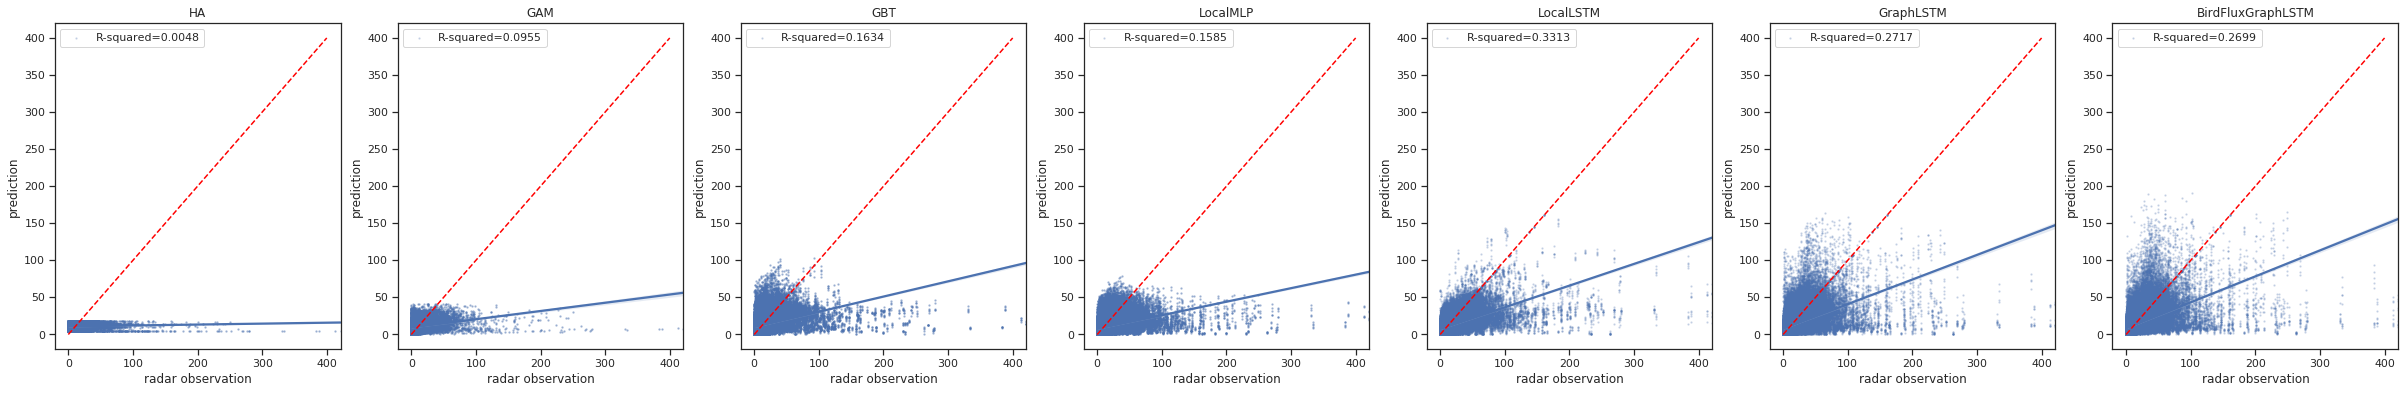

In [32]:
fig = utils.plot_results_scatter(results_km2, max=400, legend=True)

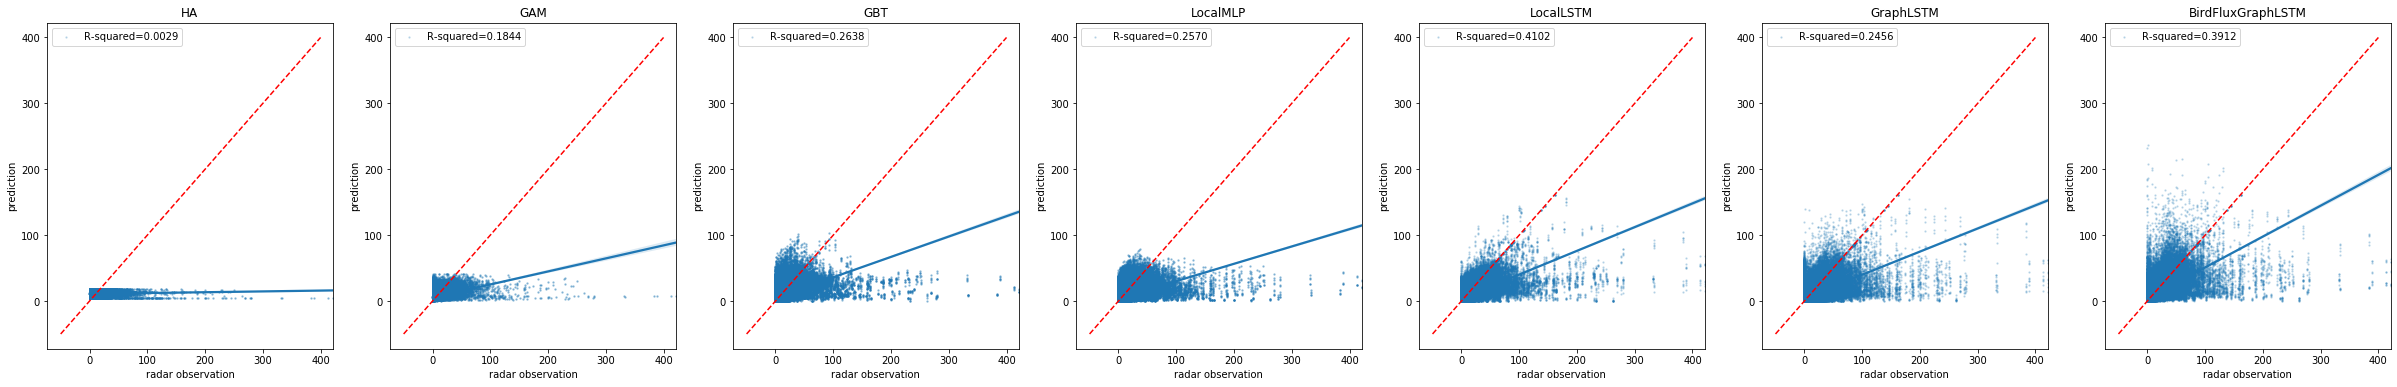

In [19]:
fig = utils.plot_results_scatter(results_dummy1, min=-50, max=400, legend=True)

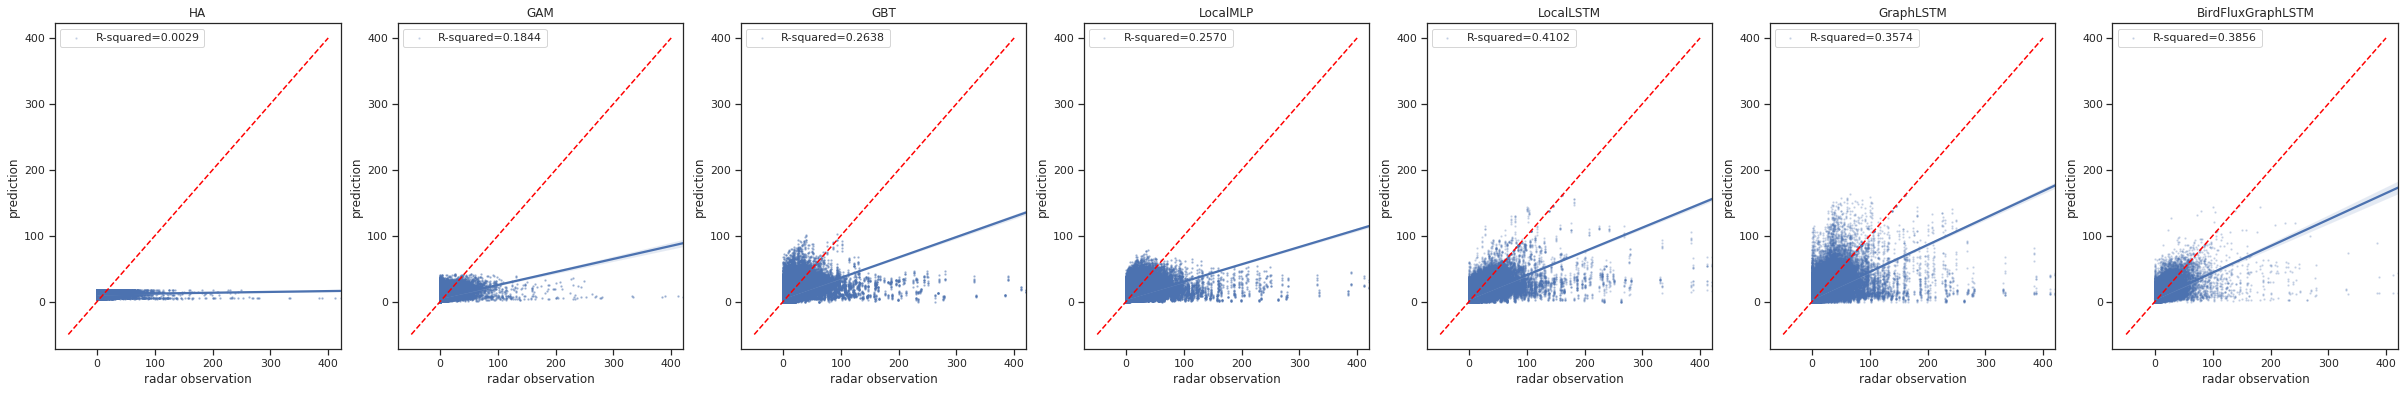

In [62]:
fig = utils.plot_results_scatter(results_enforced, min=-50, max=400, legend=True)

### Radar observations vs. predicted bird density for **power-transformed data with exponent p=1/3**

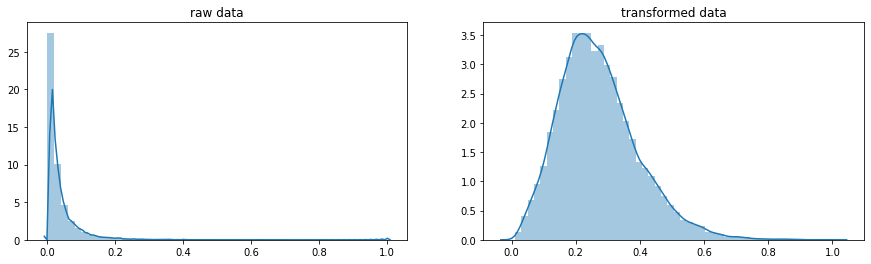

In [12]:
p = 1/3
data = results['HA'].query('night == True & missing == False & gt > 0')['gt'].values
data_transformed = np.power(data, p)
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
sb.distplot(data / np.nanmax(data), ax= ax[0])
sb.distplot(data_transformed / np.nanmax(data_transformed), ax= ax[1])
ax[0].set_title('raw data')
ax[1].set_title('transformed data');

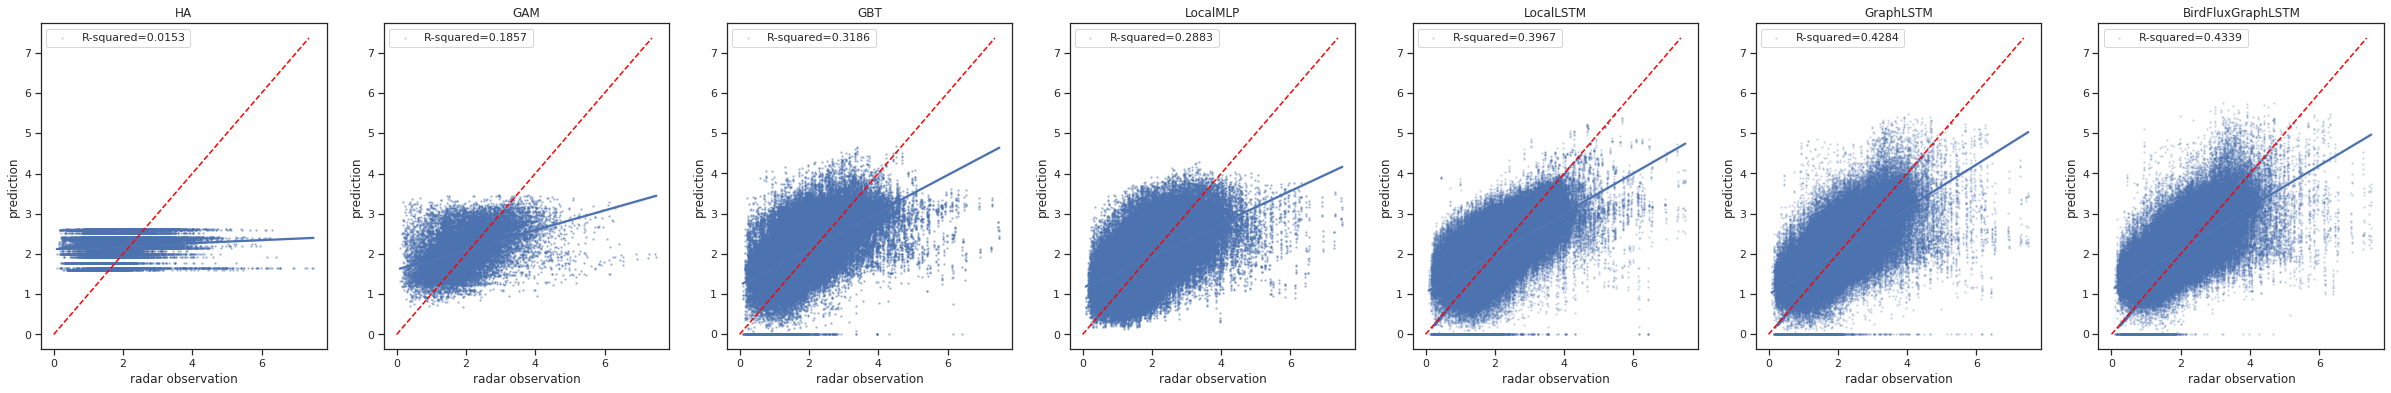

In [31]:
fig = utils.plot_results_scatter(results_km2, max=400, root_transform=3, legend=True)

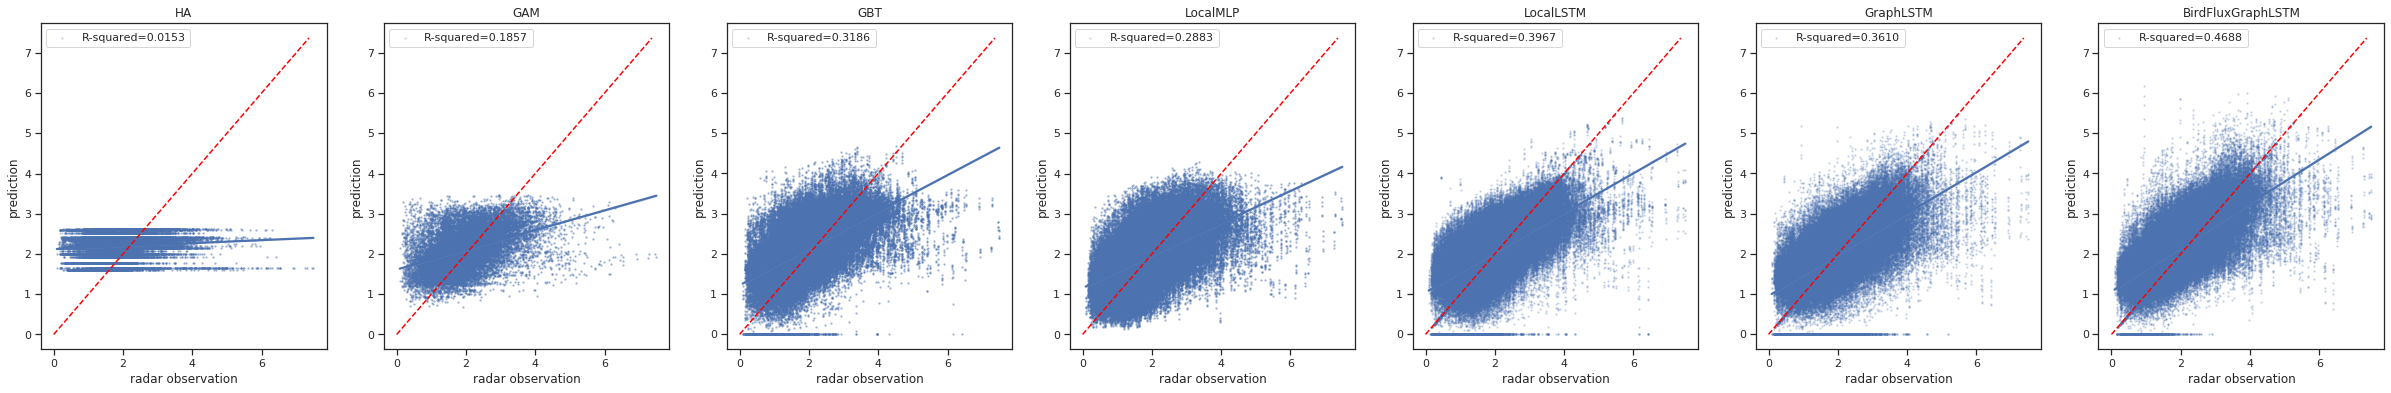

In [19]:
fig = utils.plot_results_scatter(results_dummy1, max=400, root_transform=3, legend=True)

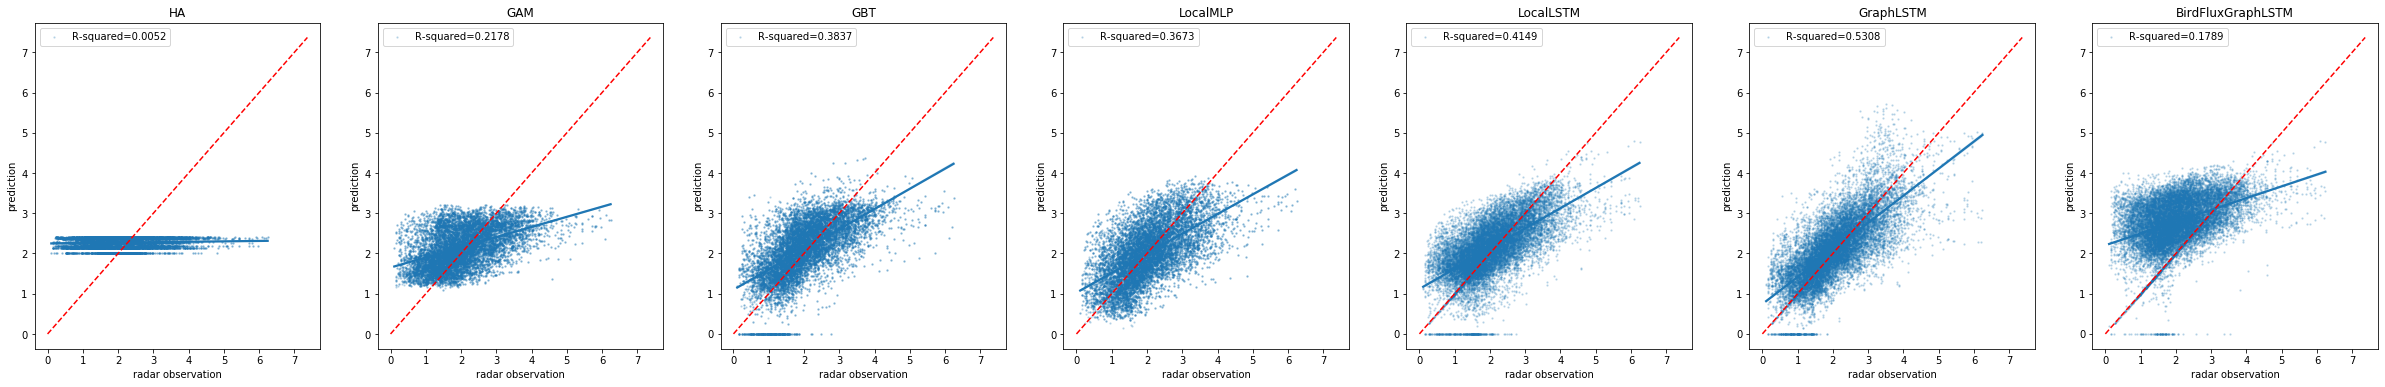

In [37]:
fig = utils.plot_results_scatter(results_fixed_boundary, max=400, root_transform=3, legend=True, trial=0, boundary=boundary)

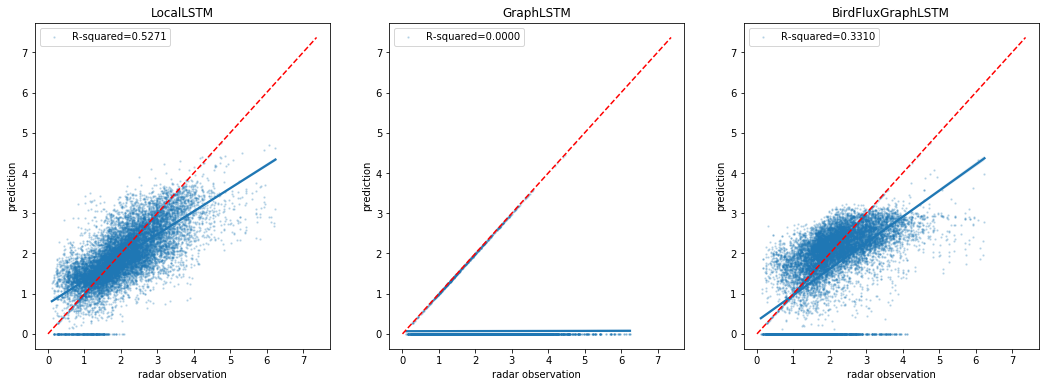

In [17]:
fig = utils.plot_results_scatter(results_root, max=400, root_transform=3, legend=True, trial=0, boundary=boundary)

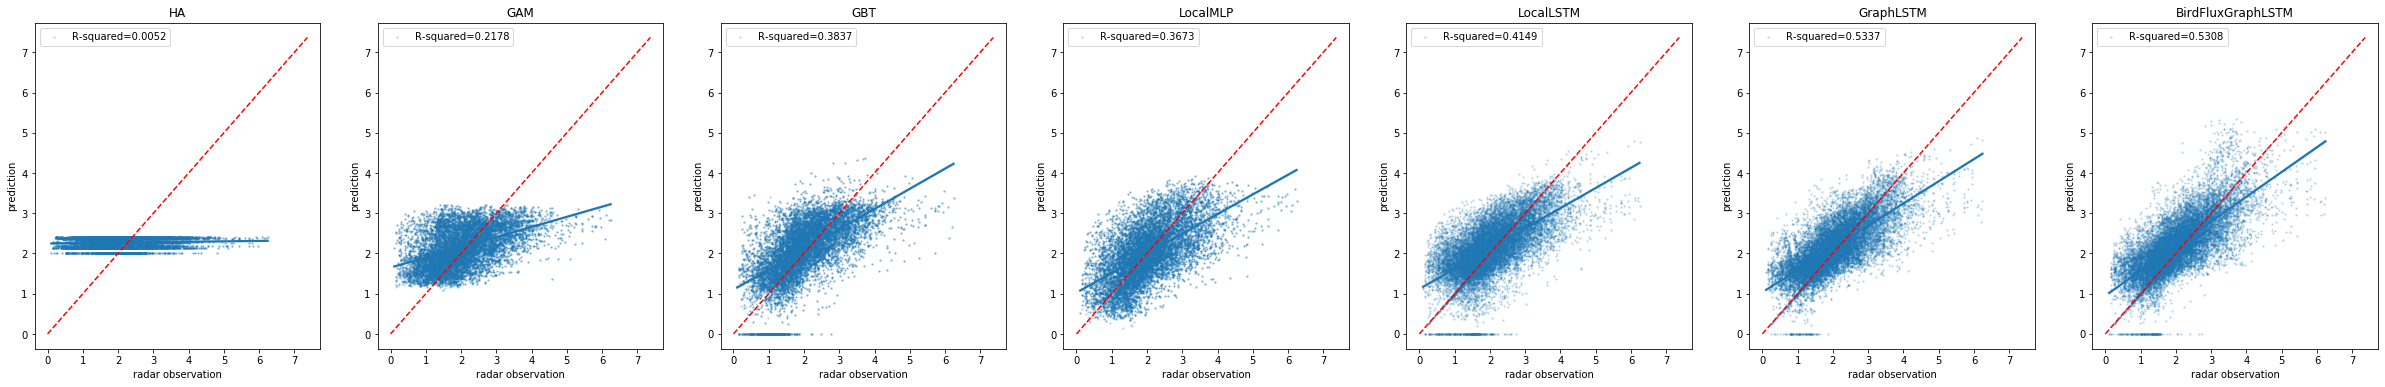

In [18]:
fig = utils.plot_results_scatter(results_km2, max=400, root_transform=3, legend=True, trial=0, boundary=boundary)

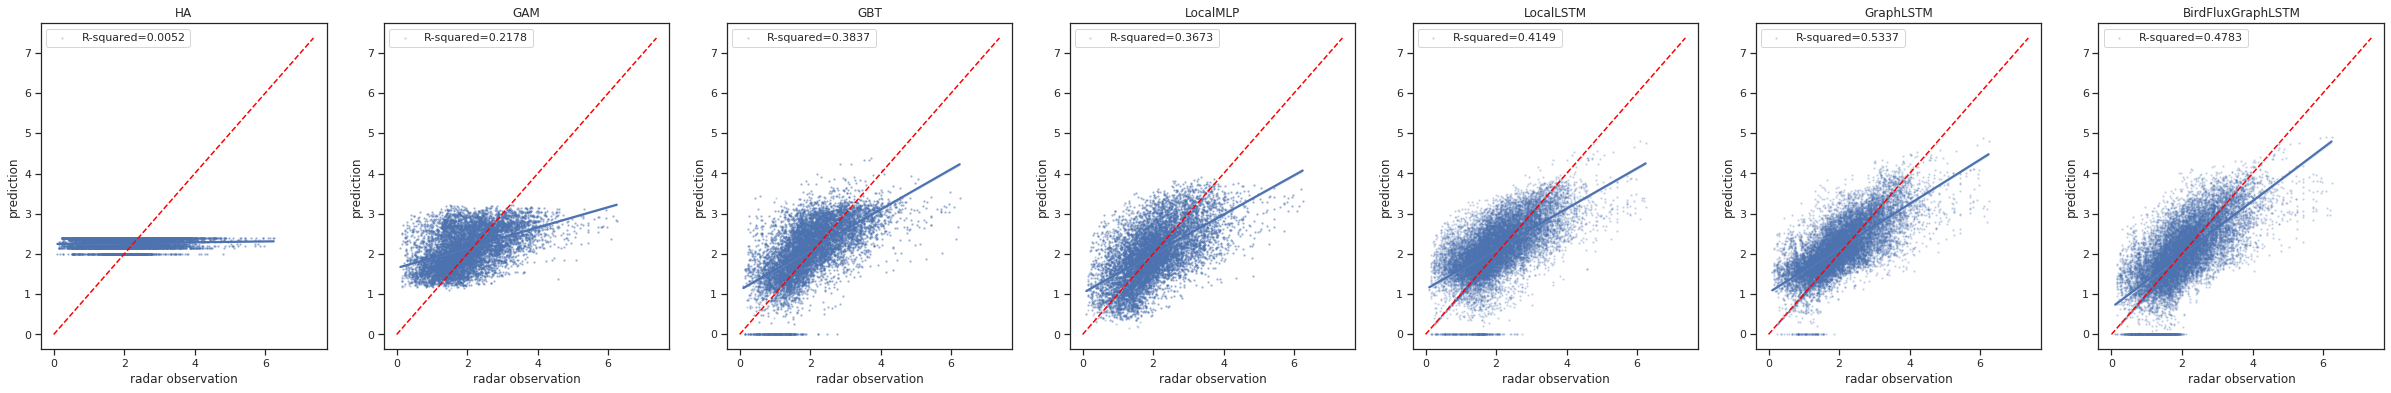

In [61]:
fig = utils.plot_results_scatter(results_enforced, max=400, root_transform=3, legend=True, trial=0, boundary=boundary)

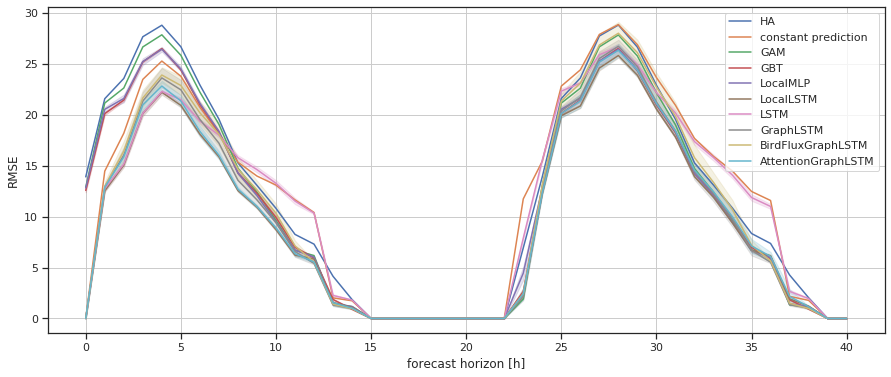

In [61]:
fig = utils.plot_errors(results_km2)

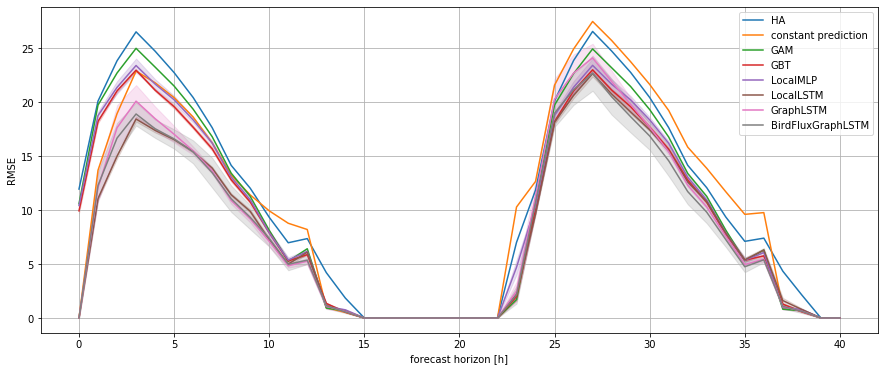

In [15]:
fig = utils.plot_errors(results_fixed_boundary, boundary=boundary)

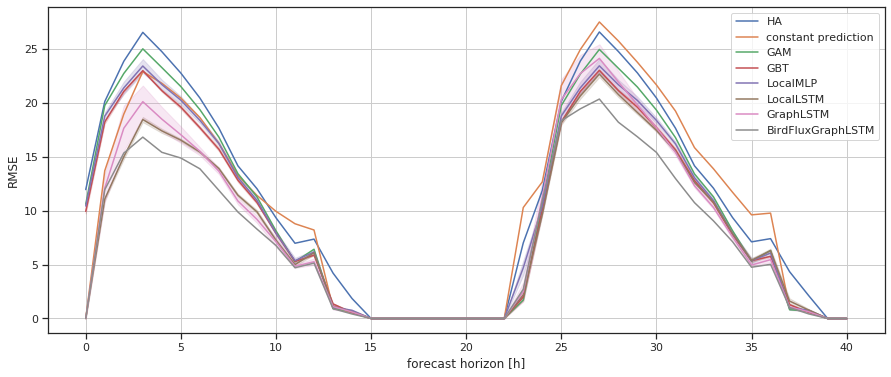

In [82]:
fig = utils.plot_errors(results_fixed_boundary, boundary=boundary)

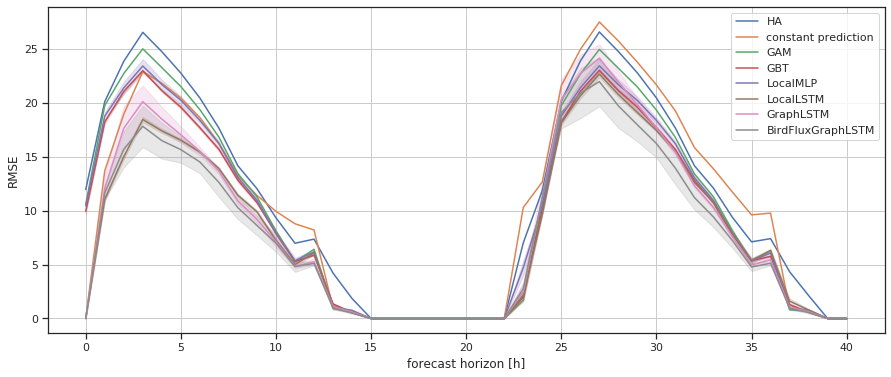

In [21]:
fig = utils.plot_errors(results_fixed_boundary, boundary=boundary)

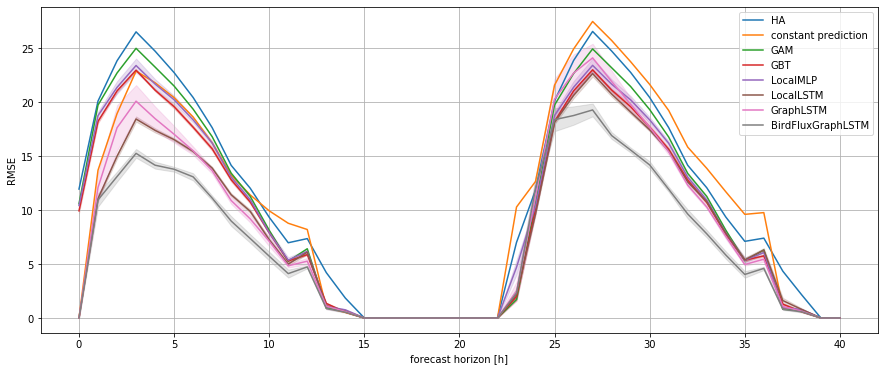

In [8]:
fig = utils.plot_errors(results_fixed_boundary_enforced, boundary=boundary)

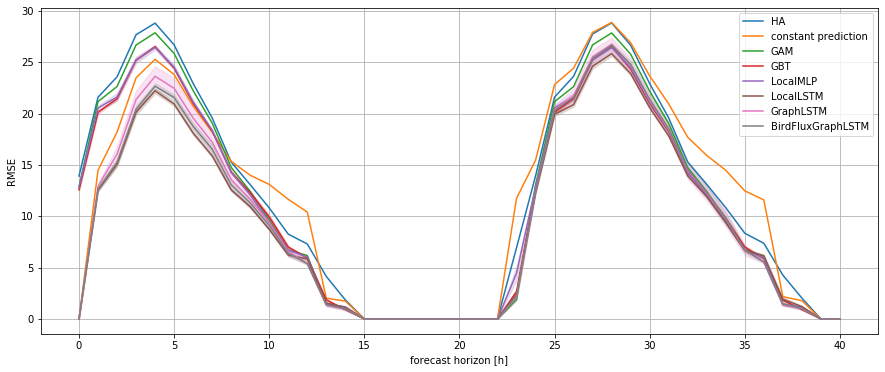

In [9]:
fig = utils.plot_errors(results_enforced)

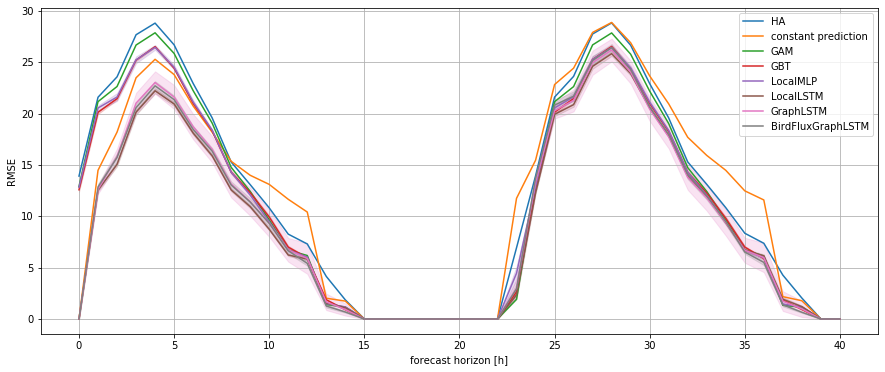

In [10]:
fig = utils.plot_errors(results_dummy1)

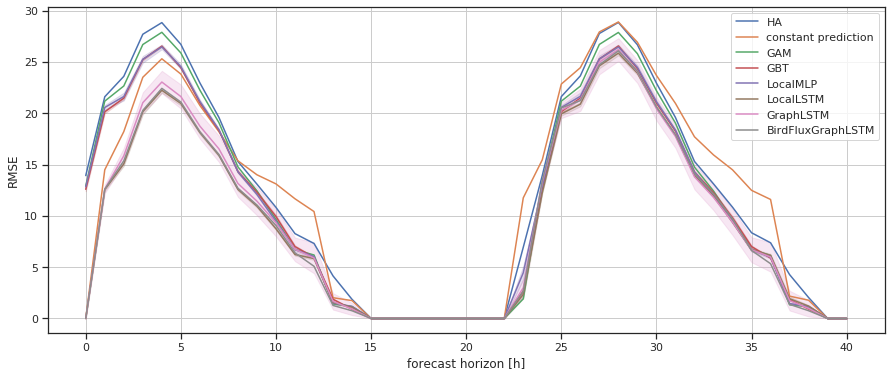

In [92]:
fig = utils.plot_errors(results_dummy1)

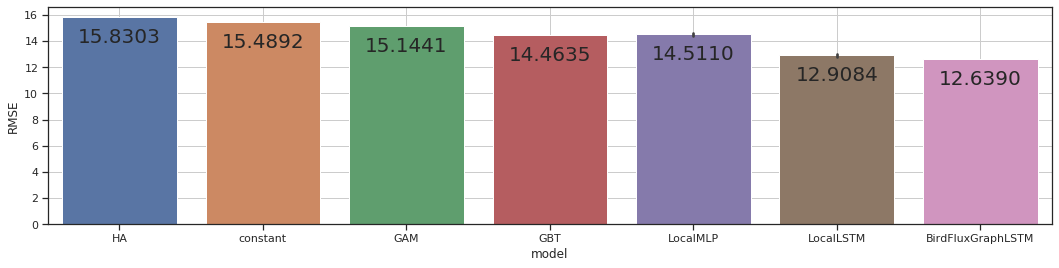

In [12]:
fig = utils.plot_average_errors(results_km2)

### RMSE based on birds/km^2

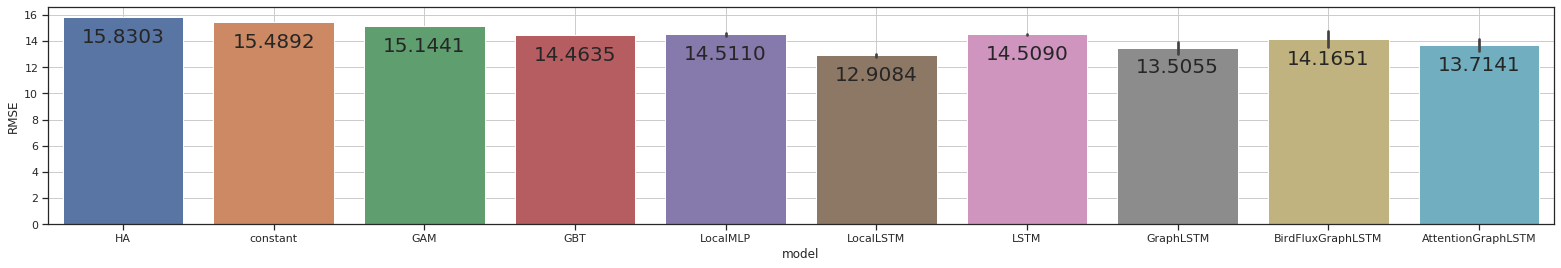

In [5]:
fig = utils.plot_average_errors(results_km2)

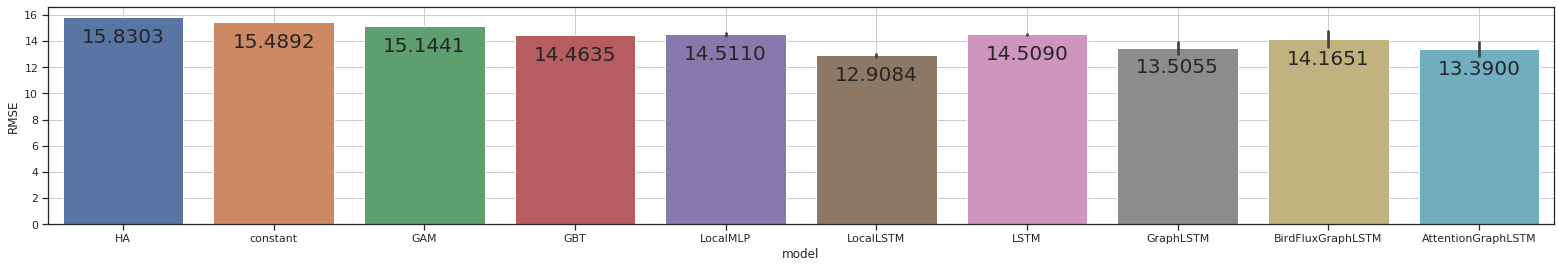

In [12]:
fig = utils.plot_average_errors(results_km2)

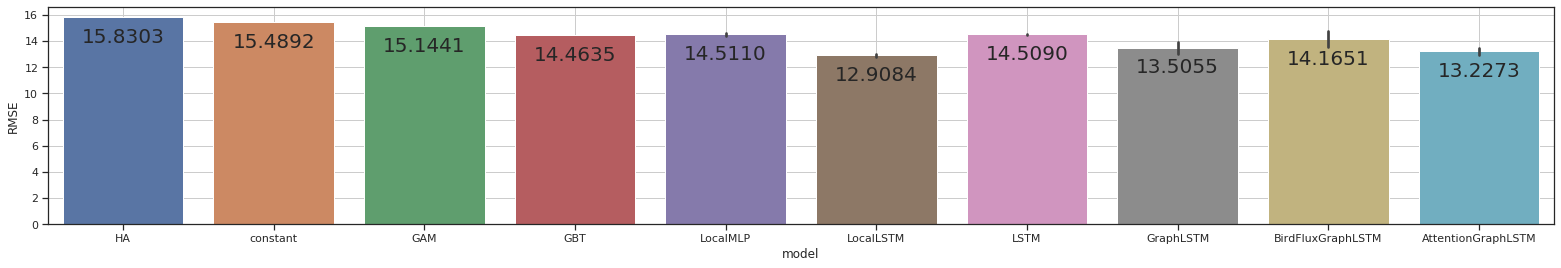

In [60]:
fig = utils.plot_average_errors(results_km2)

In [ ]:
fig = utils.plot_average_errors(results_km2, boundary=boundary)

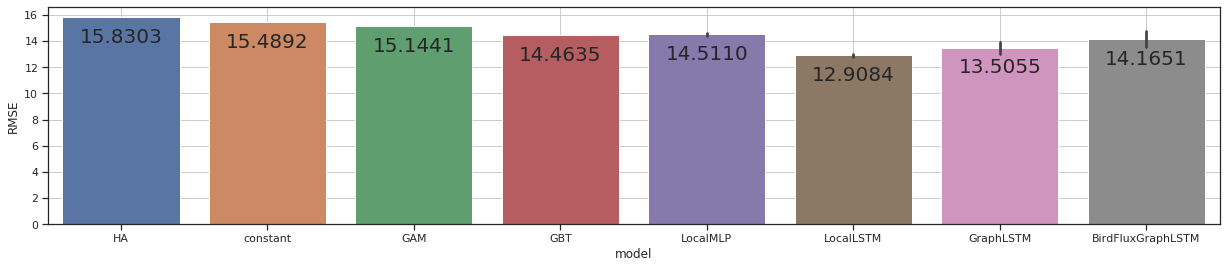

In [20]:
fig = utils.plot_average_errors(results_km2)

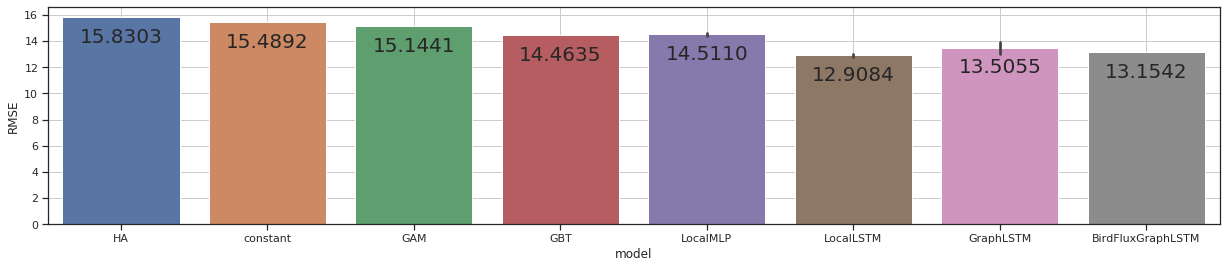

In [57]:
fig = utils.plot_average_errors(results_enforced)

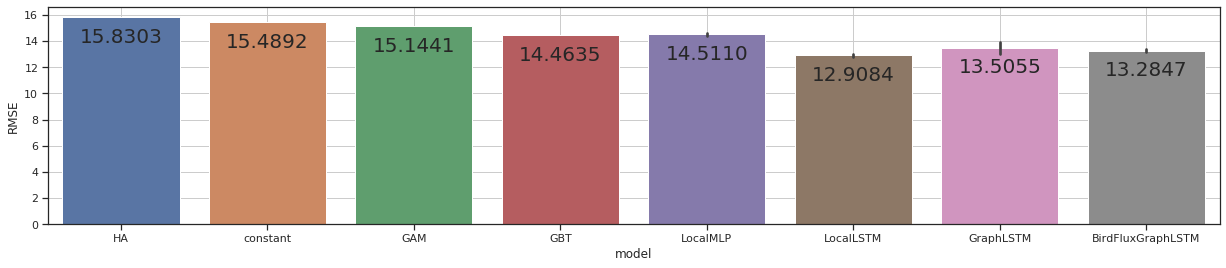

In [11]:
fig = utils.plot_average_errors(results_enforced)

#### Only hours with > 50 birds/km^2

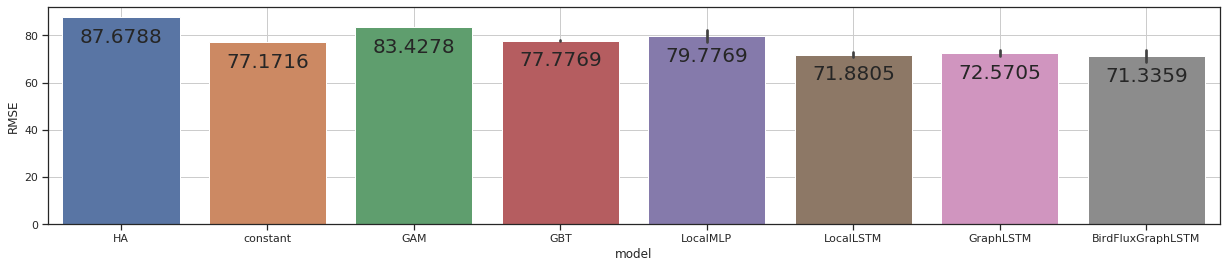

In [29]:
fig = utils.plot_average_errors(results_km2, bird_thr=50)

#### Fixed boundary cells

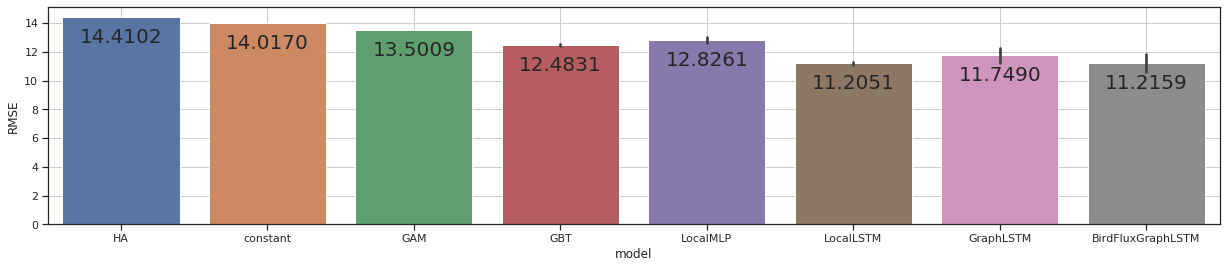

In [38]:
fig = utils.plot_average_errors(results_fixed_boundary, boundary=boundary)

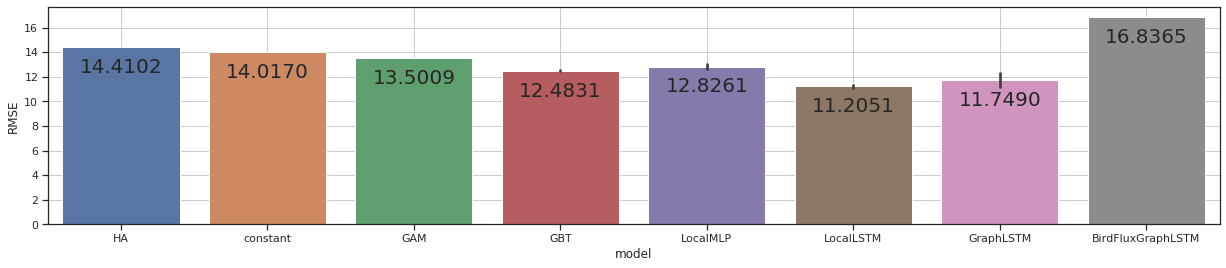

In [38]:
fig = utils.plot_average_errors(results_fixed_boundary, boundary=boundary)

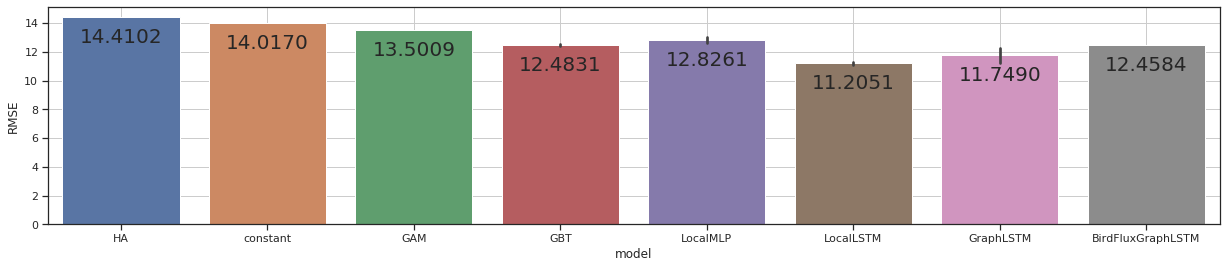

In [50]:
fig = utils.plot_average_errors(results_fixed_boundary, boundary=boundary)

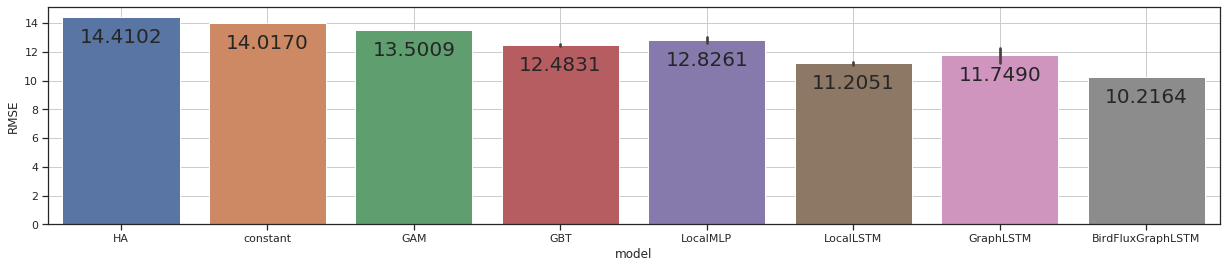

In [68]:
fig = utils.plot_average_errors(results_fixed_boundary, boundary=boundary)

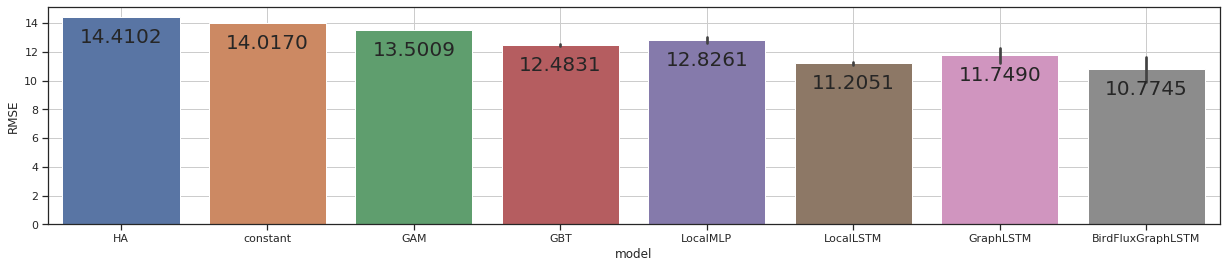

In [18]:
fig = utils.plot_average_errors(results_fixed_boundary, boundary=boundary)

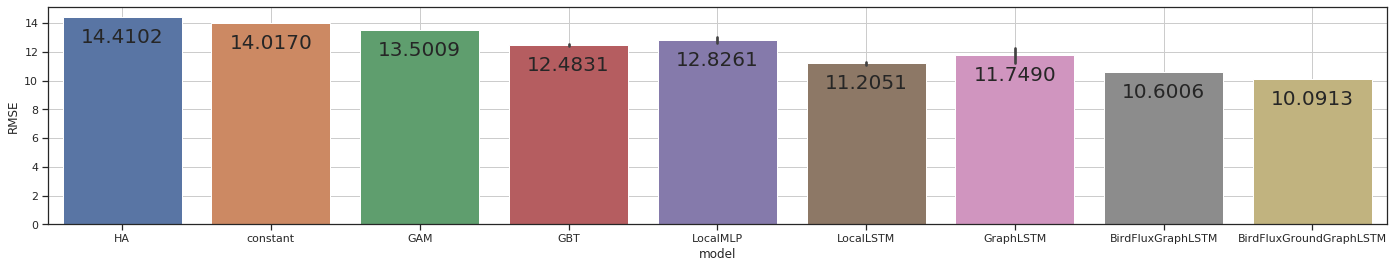

In [6]:
fig = utils.plot_average_errors(results_fixed_boundary_enforced, boundary=boundary)

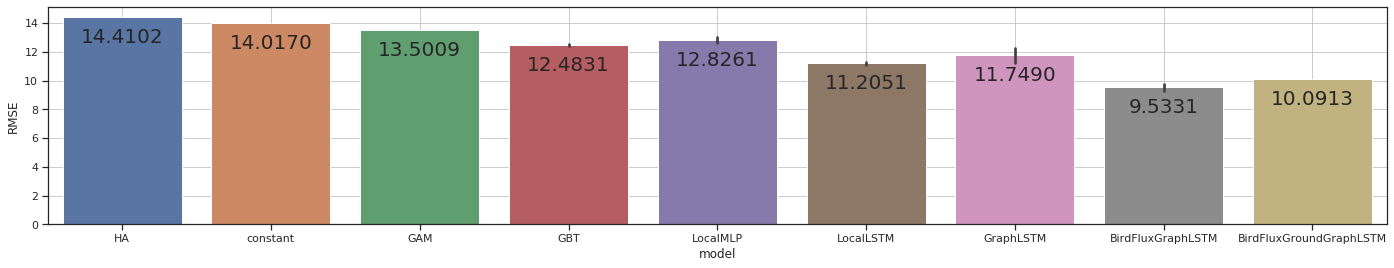

In [43]:
fig = utils.plot_average_errors(results_fixed_boundary_enforced, boundary=boundary)

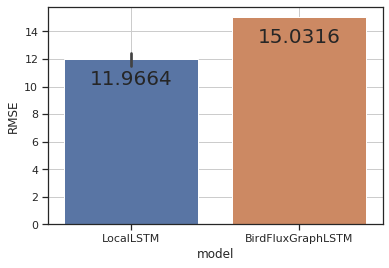

In [48]:
fig = utils.plot_average_errors(results_root, boundary=boundary)

#### Dummy radars at boundary

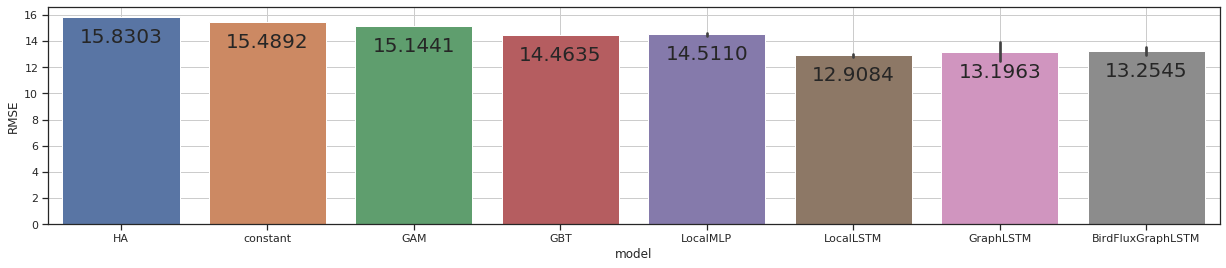

In [39]:
fig = utils.plot_average_errors(results_dummy1)

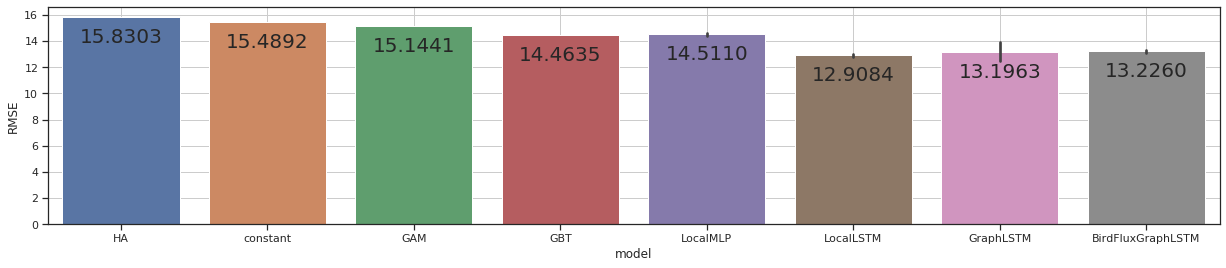

In [13]:
fig = utils.plot_average_errors(results_dummy1)

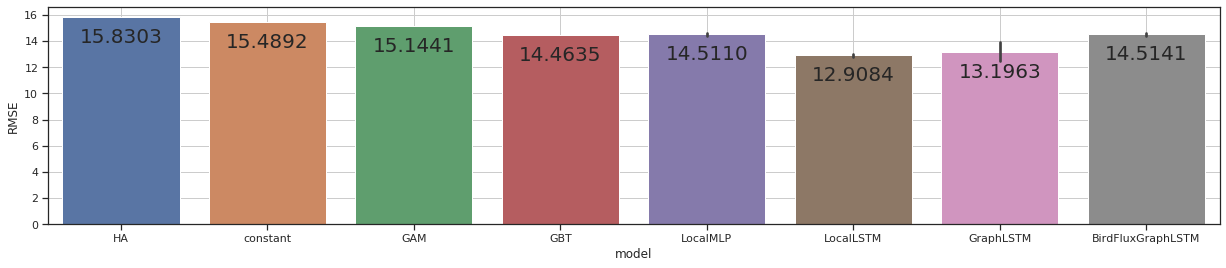

In [97]:
fig = utils.plot_average_errors(results_dummy1)

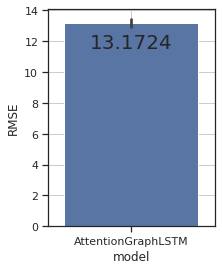

In [15]:
fig = utils.plot_average_errors(results_transformed)

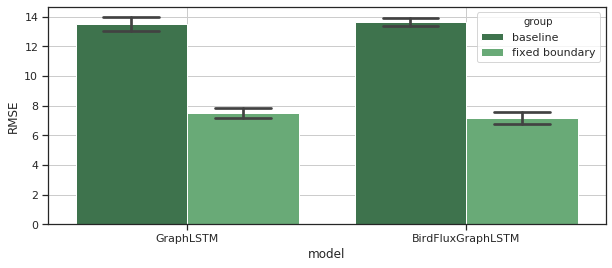

In [18]:
fig = utils.plot_average_errors_comparison(['GraphLSTM', 'BirdFluxGraphLSTM'], 
                                           results_km2, results_fixed_boundary, 
                                           ['baseline', 'fixed boundary'])

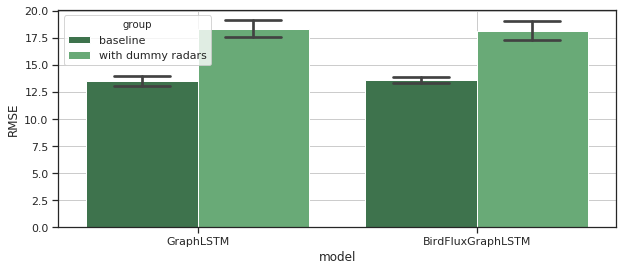

In [19]:
fig = utils.plot_average_errors_comparison(['GraphLSTM', 'BirdFluxGraphLSTM'], 
                                           results_km2, results_dummy1, 
                                           ['baseline', 'with dummy radars'])

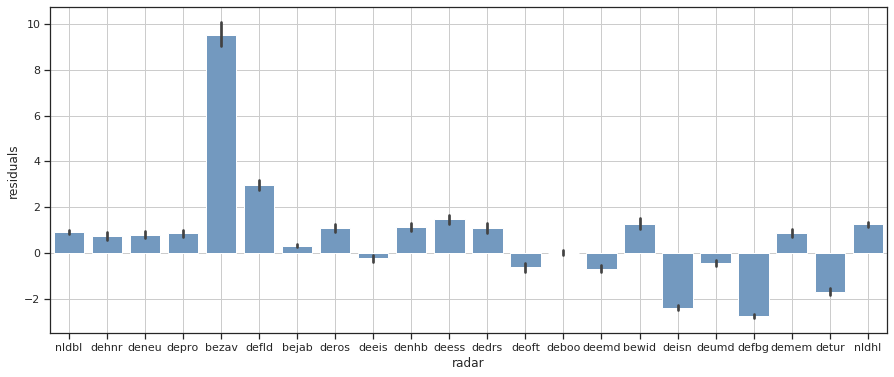

In [19]:
fig = utils.plot_errors_per_radar(results_km2, 'LocalLSTM')

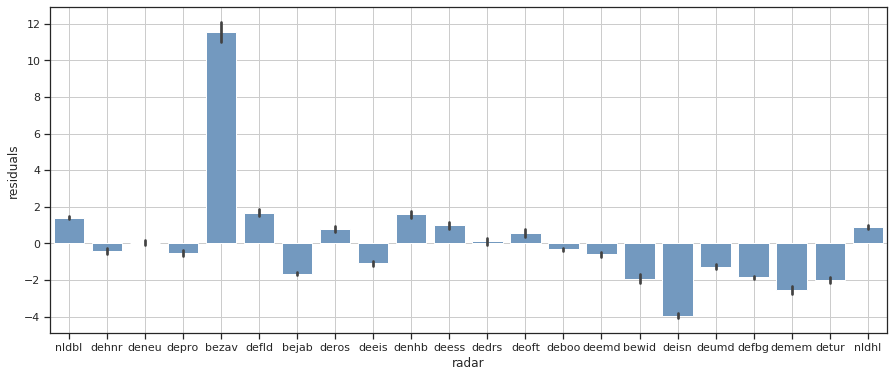

In [20]:
fig = utils.plot_errors_per_radar(results_enforced, 'BirdFluxGraphLSTM')

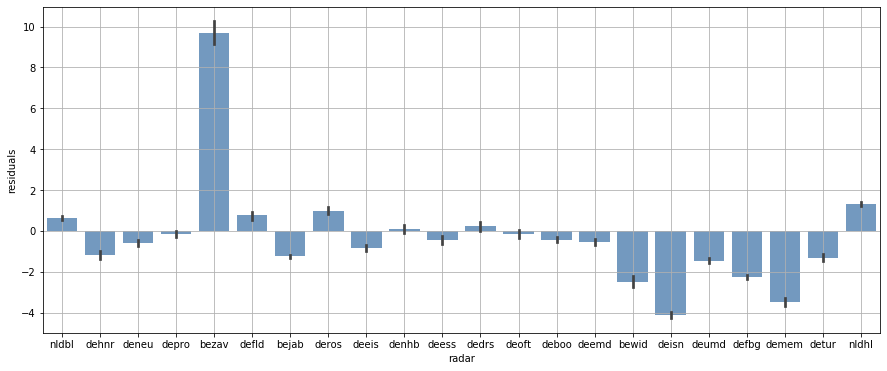

In [11]:
fig = utils.plot_errors_per_radar(results_dummy1, 'BirdFluxGraphLSTM')

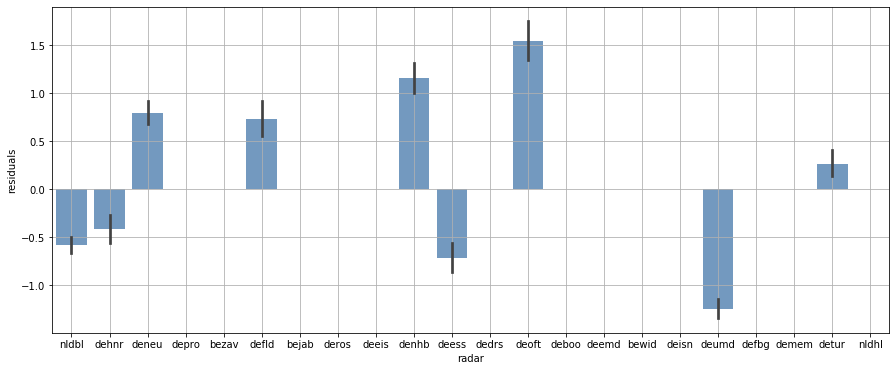

In [12]:
fig = utils.plot_errors_per_radar(results_fixed_boundary_enforced, 'BirdFluxGraphLSTM')

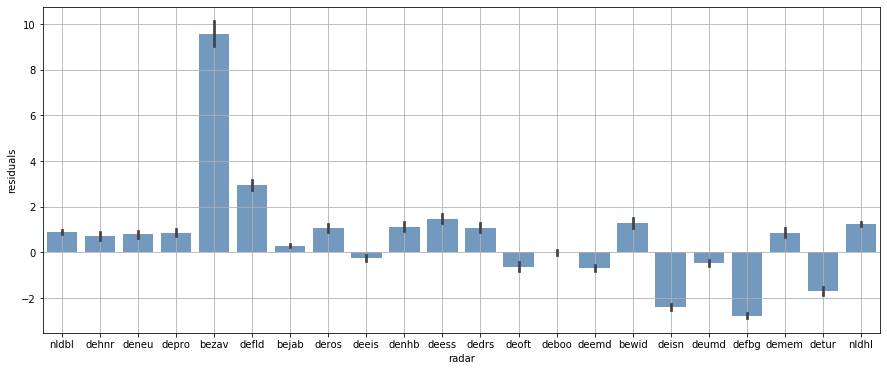

In [13]:
fig = utils.plot_errors_per_radar(results_fixed_boundary, 'LocalLSTM')

### Correlation of residuals

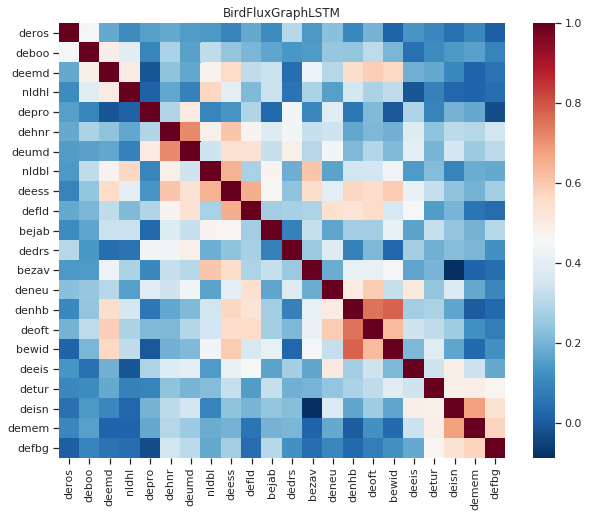

In [25]:
fig = utils.residuals_corr(results_dummy1, ['BirdFluxGraphLSTM'], voronoi)

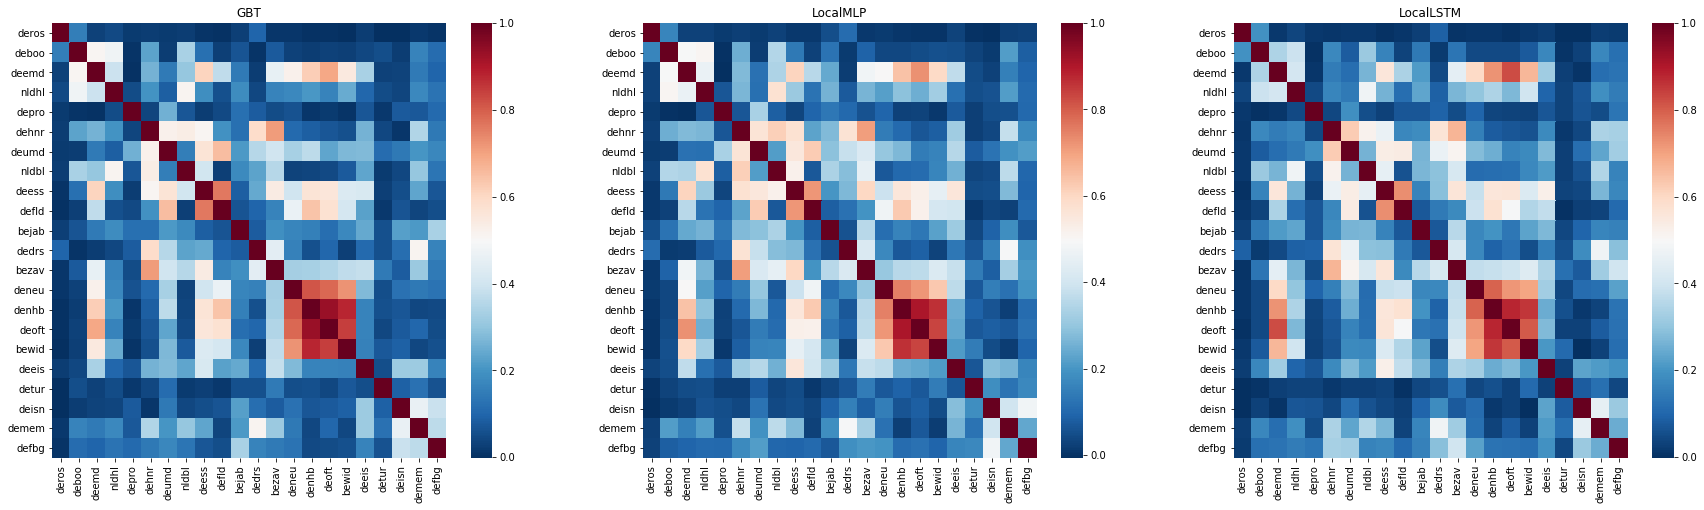

In [14]:
fig = utils.residuals_corr(results_km2, ['GBT', 'LocalMLP', 'LocalLSTM'], voronoi)

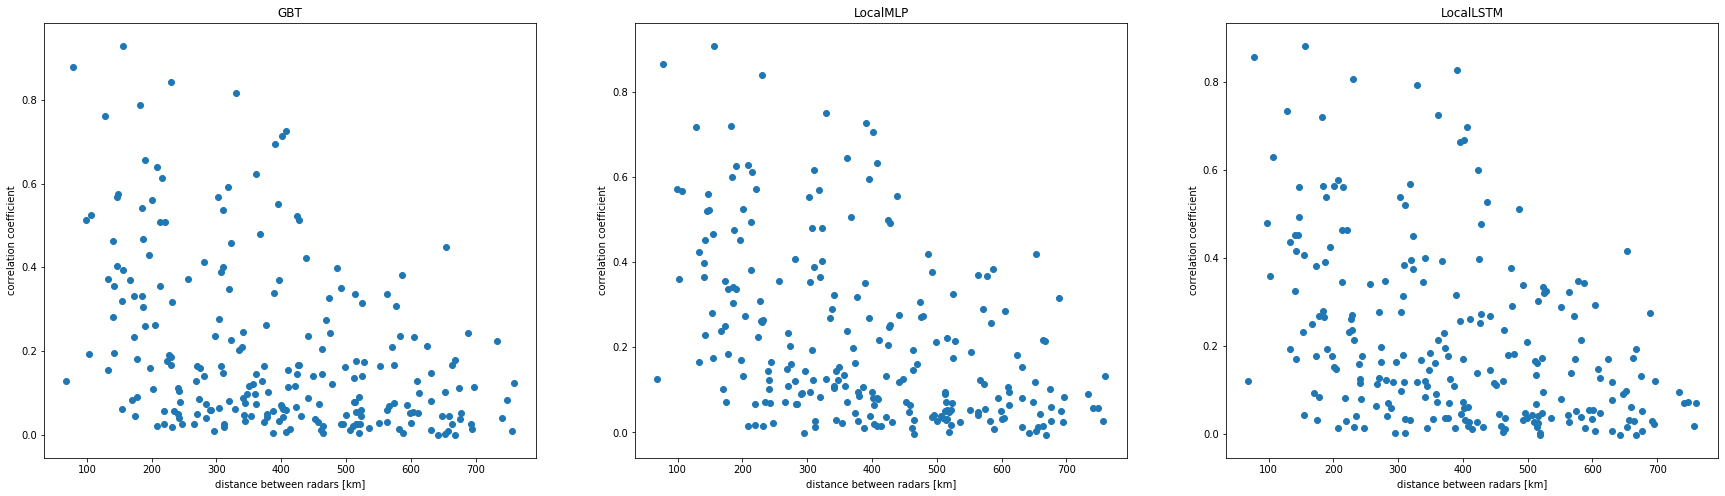

In [15]:
fig = utils.residuals_corr_vs_distance(results_km2, ['GBT', 'LocalMLP', 'LocalLSTM'], voronoi)

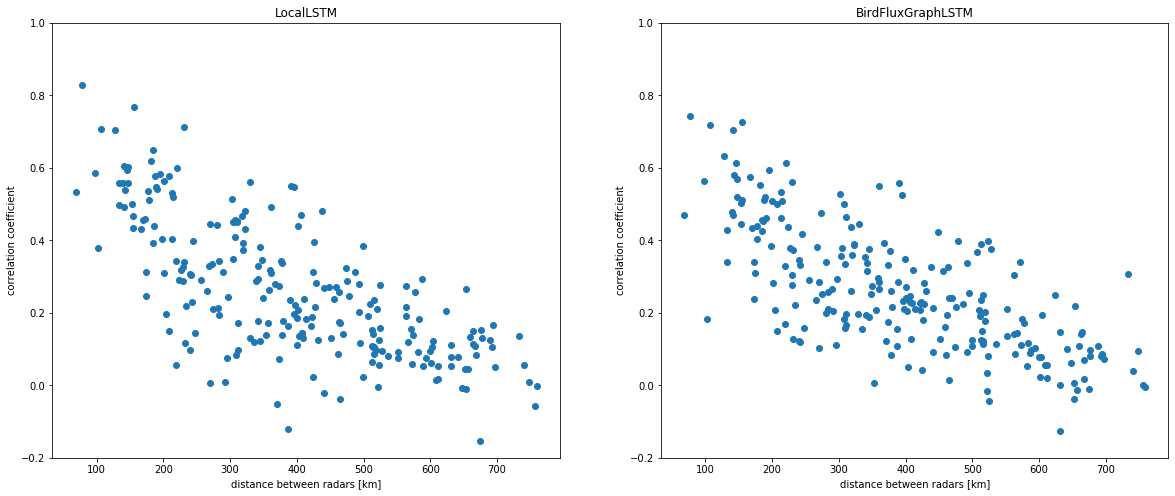

In [11]:
fig = utils.residuals_corr_vs_distance(results_dummy1, ['LocalLSTM', 'BirdFluxGraphLSTM'], voronoi)

In [8]:
import networkx as nx
voronoi = gpd.read_file('/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0/radar/fall/2016/voronoi.shp')
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0/radar/fall/2016/delaunay.gpickle'
G = nx.read_gpickle(G_path)
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/max_dist_dummy_radars=0/radar/fall/2016/delaunay.gpickle'
G = nx.read_gpickle(G_path)

In [81]:
G_new = nx.DiGraph()
G_new.add_nodes_from(list(G.nodes(data=True)))

for i, j, e_data in G.edges(data=True):
    ri = G.nodes[i]['radar']
    rj = G.nodes[j]['radar']

f = torch.cat([f for f in fluxes[0].values()], dim=-1)
mask = np.concatenate([results_fixed_boundary_enforced['BirdFluxGraphLSTM'].query(f'seqID == {i}').groupby('horizon').night.all().values for i in range(len(fluxes[0]))])


radars = results_fixed_boundary_enforced['BirdFluxGraphLSTM'].radar.unique()
for i, ri in enumerate(radars):
    for j, rj in enumerate(radars):
        if f[i,j].mean() != 0:
            #fig, ax = plt.subplots()
            #sb.distplot(f[i,j, mask].detach().numpy(), kde=False, ax=ax)
            #ax.set_title(f'flux from {ri} to {rj}: {f[i,j]}')
            val = f[i,j,mask].mean().detach().numpy()
            boundary1 = ('boundary' in ri) and ('boundary' in rj)
            boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
            if val > 0 and not boundary1 and not boundary2:
                G_new.add_edge(j, i, flux=val)
            
# f = f.mean(-1)
# plt.imshow(f.detach().numpy())
# plt.colorbar()

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


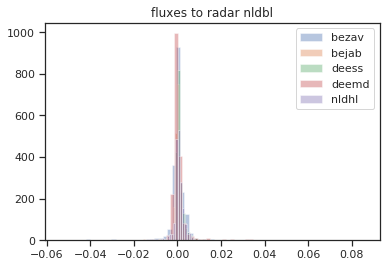

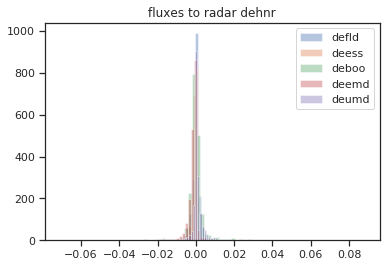

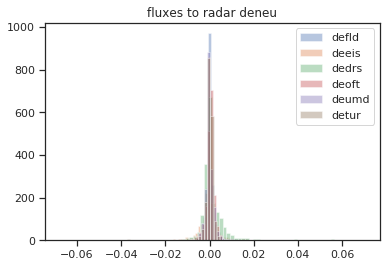

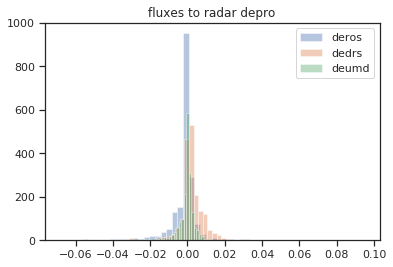

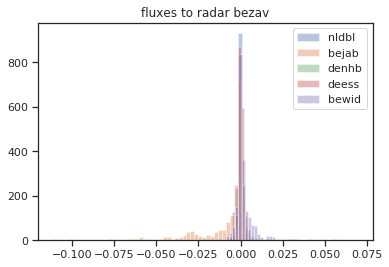

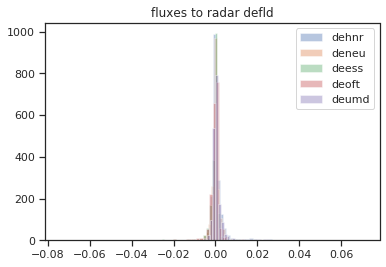

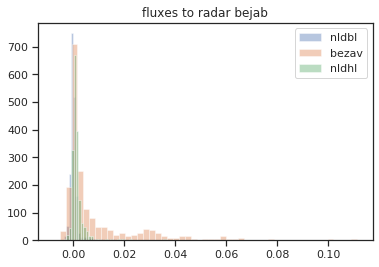

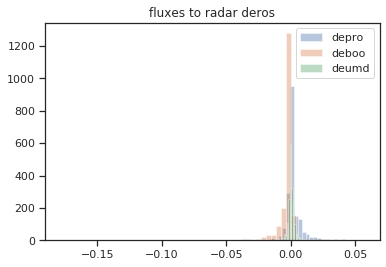

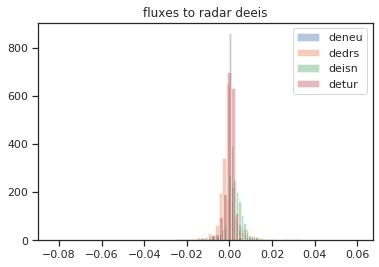

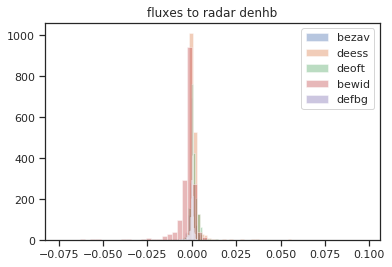

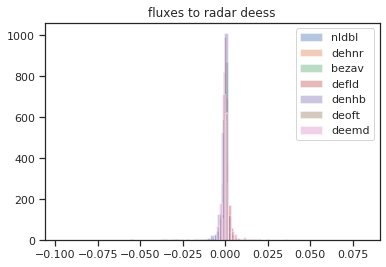

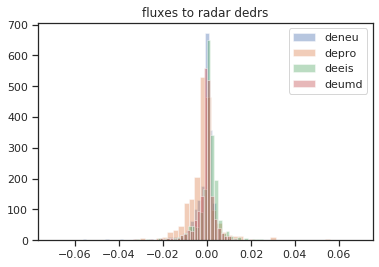

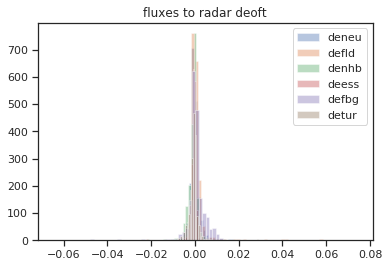

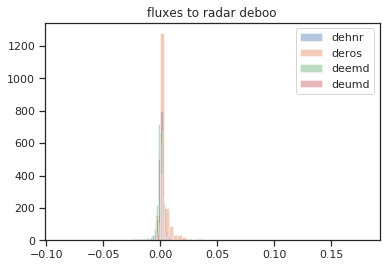

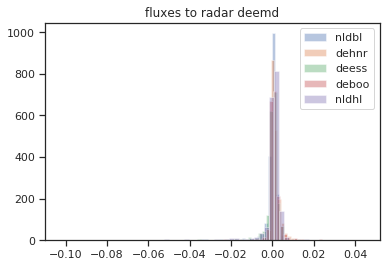

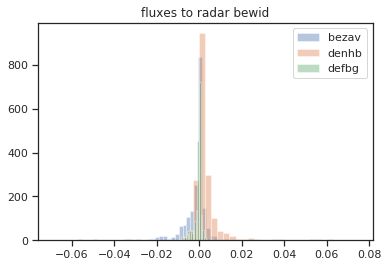

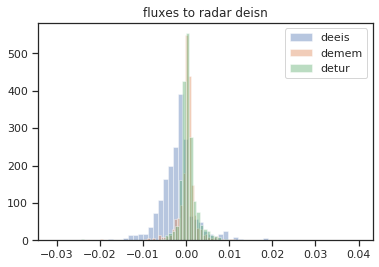

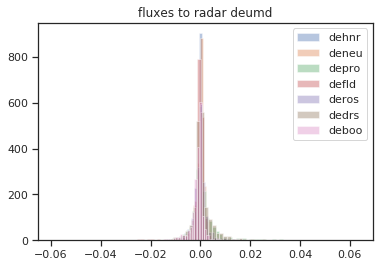

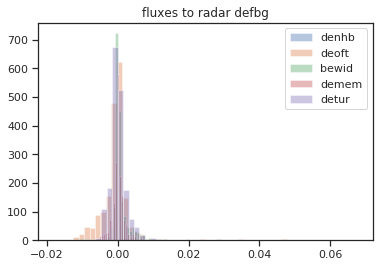

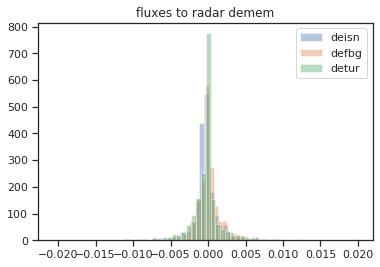

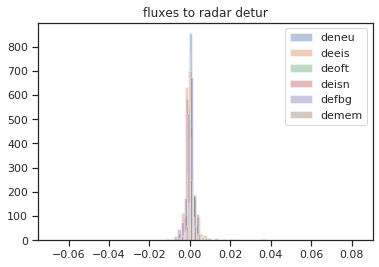

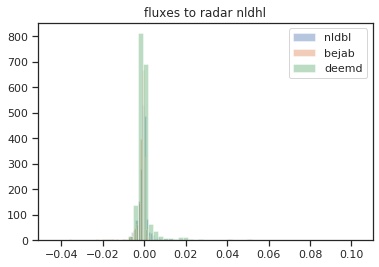

In [57]:
G_new = nx.DiGraph()
G_new.add_nodes_from(list(G.nodes(data=True)))
f = torch.cat([f for f in fluxes[0].values()], dim=-1)
mask = np.concatenate([results_fixed_boundary_enforced['BirdFluxGraphLSTM'].query(f'seqID == {i}').groupby('horizon').night.all().values for i in range(len(fluxes[0]))])

radars = results_fixed_boundary_enforced['BirdFluxGraphLSTM'].radar.unique()
for i, ri in enumerate(radars):
    fig, ax = plt.subplots()
    for j, rj in enumerate(radars):
        if f[i,j].mean() != 0:
            sb.distplot(f[j,i, mask].detach().numpy(), kde=False, ax=ax, label=rj)
            ax.set_title(f'fluxes to radar {ri}')
            plt.legend()

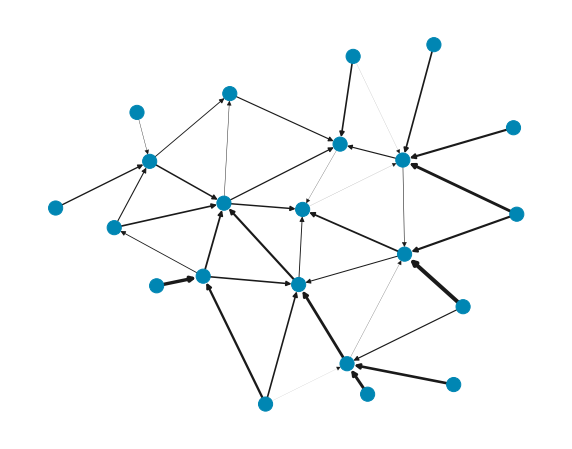

In [116]:
pos = {ridx:(voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}
cmap = cm.get_cmap('YlOrBr')
edge_widths = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
edge_widths /= 0.25 * edge_widths.max()
node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
fig, ax = plt.subplots(figsize=(10,8))
options = {
    'arrowsize': 30,
}
nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, options={'arrowsize': edge_widths*100})

/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.
/home/fiona/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


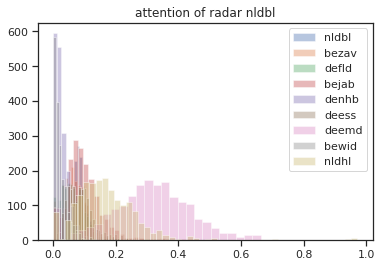

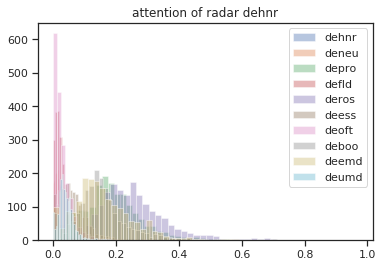

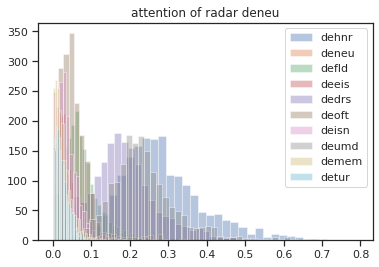

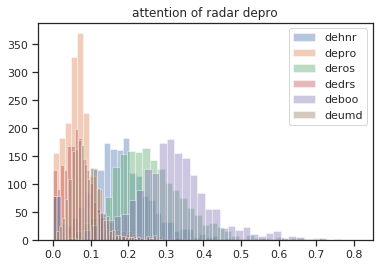

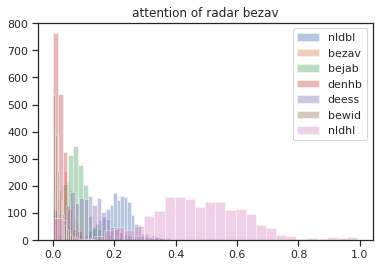

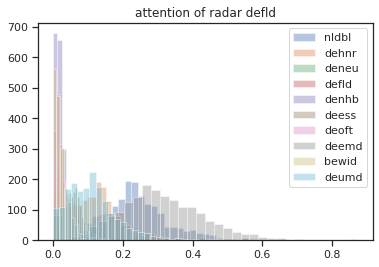

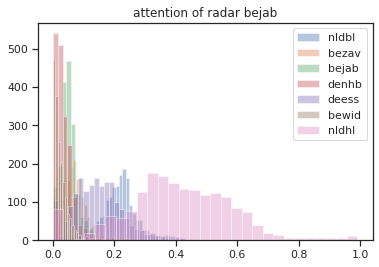

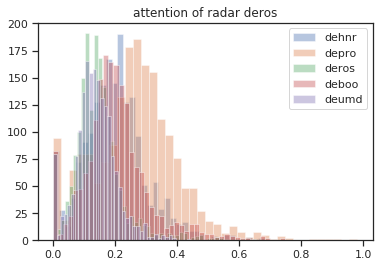

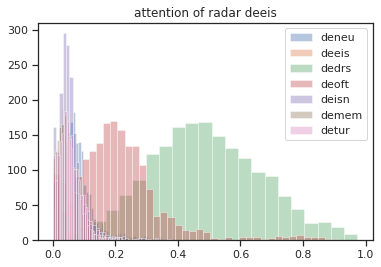

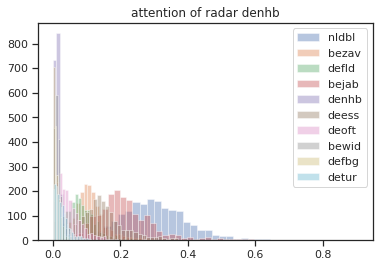

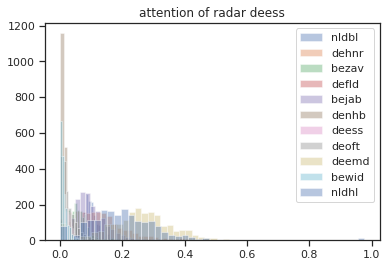

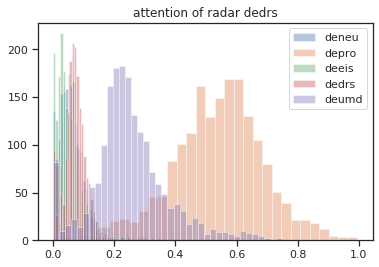

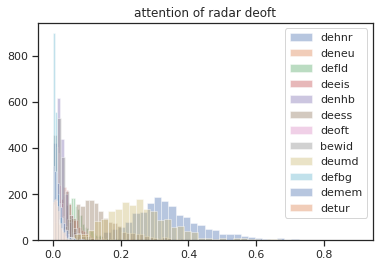

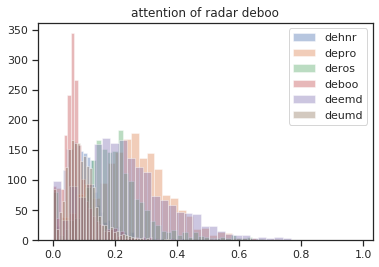

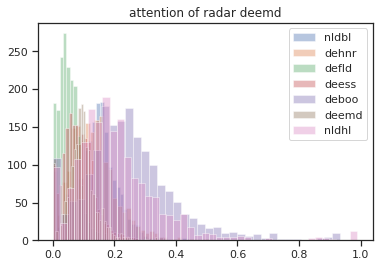

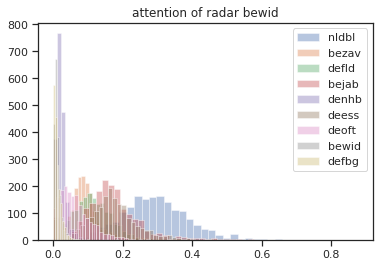

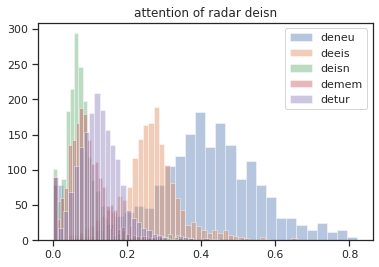

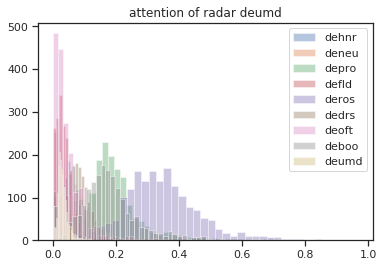

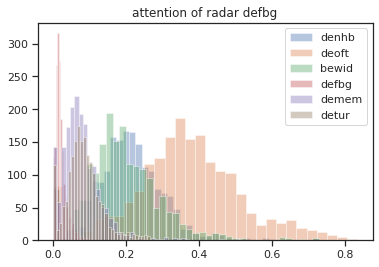

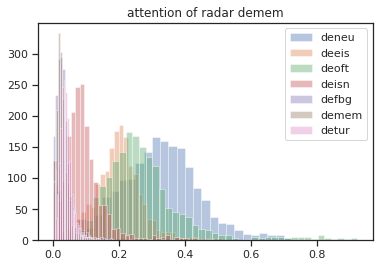

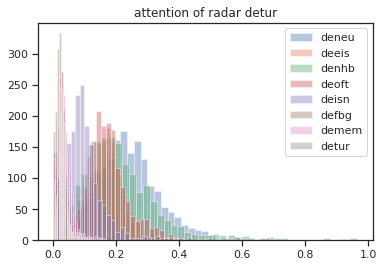

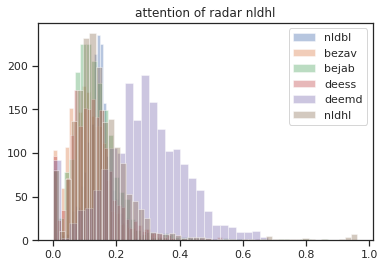

In [9]:
G_att = nx.DiGraph()
G_att.add_nodes_from(list(G.nodes(data=True)))

f = torch.cat([f for f in att[0].values()], dim=-1)
mask = np.concatenate([results_att['AttentionGraphLSTM'].query(f'seqID == {i}').groupby('horizon').night.all().values for i in range(len(att[0]))])


radars = results_att['AttentionGraphLSTM'].radar.unique()
for i, ri in enumerate(radars):
    fig, ax = plt.subplots()
    for j, rj in enumerate(radars):
        if f[i,j].mean() != 0:
            sb.distplot(f[j,i, mask].detach().numpy(), kde=False, ax=ax, label=rj)
            ax.set_title(f'attention of radar {ri}')
            plt.legend()

In [20]:
import networkx as nx
G_path = '/home/fiona/birdMigration/data/preprocessed/1H/max_dist_dummy_radars=0/radar/fall/2015/G_max_dist=400.gpickle'
G = nx.read_gpickle(G_path)

In [21]:
for i, j, data in G.edges(data=True):
    print(G.nodes[i]['radar'], G.nodes[j]['radar'], data['distance'])

nldbl nldbl 0.0
nldbl dehnr 310.70489761899955
nldbl bezav 142.27729408042094
nldbl defld 265.4204176259237
nldbl bejab 177.88929946431003
nldbl denhb 241.53921820647628
nldbl deess 145.76706810479956
nldbl deoft 341.8346439083933
nldbl deboo 389.01781645086095
nldbl deemd 185.87457534034357
nldbl bewid 244.4981420910922
nldbl nldhl 98.20895858430526
dehnr nldbl 310.70489761899955
dehnr dehnr 0.0
dehnr deneu 239.9105751784239
dehnr depro 283.10433163881703
dehnr defld 141.83155957827276
dehnr deros 247.46708325104487
dehnr deeis 376.24078554100305
dehnr denhb 341.30340697142105
dehnr deess 221.24813128798212
dehnr dedrs 317.868975073866
dehnr deoft 283.63670968220345
dehnr deboo 173.45596942188743
dehnr deemd 204.52926925642905
dehnr deumd 106.41636999873342
dehnr nldhl 335.23511630924844
bezav nldbl 142.27729408042094
bezav bezav 0.0
bezav defld 307.66056313664996
bezav bejab 102.56305796649319
bezav denhb 172.9037846058147
bezav deess 184.27214651251688
bezav deoft 319.2952740771383


In [10]:
G_att = nx.DiGraph()
G_att.add_nodes_from(list(G.nodes(data=True)))

f = torch.cat([f for f in att[0].values()], dim=-1)
mask = np.concatenate([results_att['AttentionGraphLSTM'].query(f'seqID == {i}').groupby('horizon').night.all().values for i in range(len(att[0]))])


radars = results_att['AttentionGraphLSTM'].radar.unique()
for i, ri in enumerate(radars):
    for j, rj in enumerate(radars):
        if f[i,j].mean() != 0:
            #fig, ax = plt.subplots()
            #sb.distplot(f[i,j, mask].detach().numpy(), kde=False, ax=ax)
            #ax.set_title(f'flux from {ri} to {rj}: {f[i,j]}')
            val = f[j,i,mask].mean().detach().numpy()
            G_att.add_edge(j, i, att=val)
            
# f = f.mean(-1)
# plt.imshow(f.detach().numpy())
# plt.colorbar()

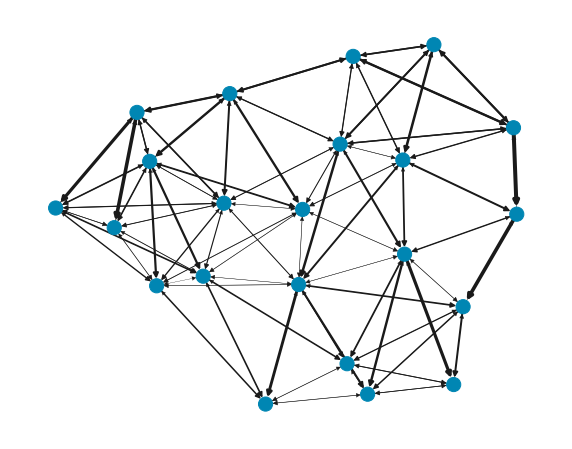

In [11]:
pos = {ridx:(voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for (ridx, name) in nx.get_node_attributes(G_att, 'radar').items()}
cmap = cm.get_cmap('YlOrBr')
edge_widths = np.array(list(nx.get_edge_attributes(G_att,'att').values()))
edge_widths /= 0.25 * edge_widths.max()
node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_att.nodes(data=True)]
fig, ax = plt.subplots(figsize=(10,8))
options = {
    'arrowsize': 30,
}
nx.draw(G_att, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, options={'arrowsize': edge_widths*100})

In [ ]:
G

In [103]:
total_fluxes = {n : 0 for n in G_new.nodes()}
for i, j, e in G_new.edges(data=True):
    total_fluxes[i] -= e['flux']
    total_fluxes[j] += e['flux']
for n, data in G_new.nodes(data=True):
    print(data['radar'], total_fluxes[n])

nldbl -2.7016772946808487e-05
bezav 0.0007004433359725226
bejab -0.0004495436223805882
deess 0.000629370755632408
deemd 0.00036332717240838974
nldhl -0.00014377680213328858
boundary_0 0.000202928588805662
dehnr 0.0004416701995069161
defld 0.0005423399015853647
deboo 0.00028486554947448894
deumd 0.001314470104262
deneu 0.000323917658533901
deeis -0.00014546437887474895
dedrs 0.0014295054133981466
deoft 5.263646016828716e-06
detur 0.0009500311134615913
depro 0.001698215986834839
deros 0.0005515935190487653
boundary_5 -0.001925608521560207
boundary_6 -0.0037736522499471903
denhb 0.0011514046636875719
bewid -0.001101556666981196
boundary_13 -0.00014835209412922268
boundary_14 0.00024235730234067887
boundary_3 -0.0009603337166481651
boundary_4 -0.0009587443782947958
deisn -0.0010757145937532187
boundary_7 -0.004375214222818613
boundary_8 -0.003440888598561287
defbg 0.0007221477280836552
boundary_12 0.001565927785122767
boundary_2 -0.00022121374786365777
boundary_1 0.000179754315468017
demem

tensor(nan, grad_fn=<MeanBackward0>)


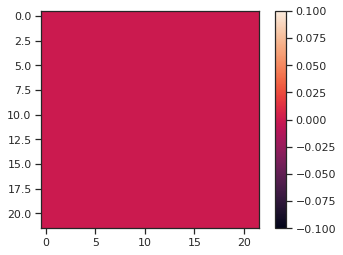

In [43]:
f = torch.cat([f for f in fluxes[0].values()], dim=-1)
ft = f.permute(1,0,2)
delta = (f + ft)
mask = (f != 0)
constraint = torch.mean((delta**2)[mask])
print(constraint)
delta = delta.mean(-1)
plt.imshow(delta.detach().numpy())
plt.colorbar()

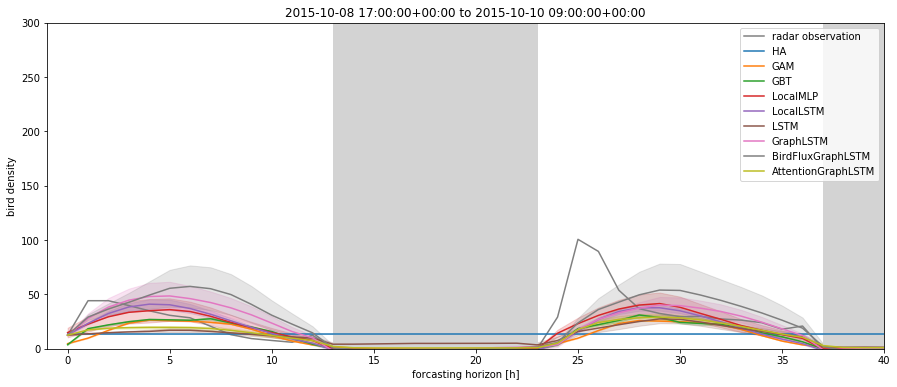

In [19]:
nidx=42
fig = utils.plot_example_prediction(results_km2, 'deoft', nidx, max=300)

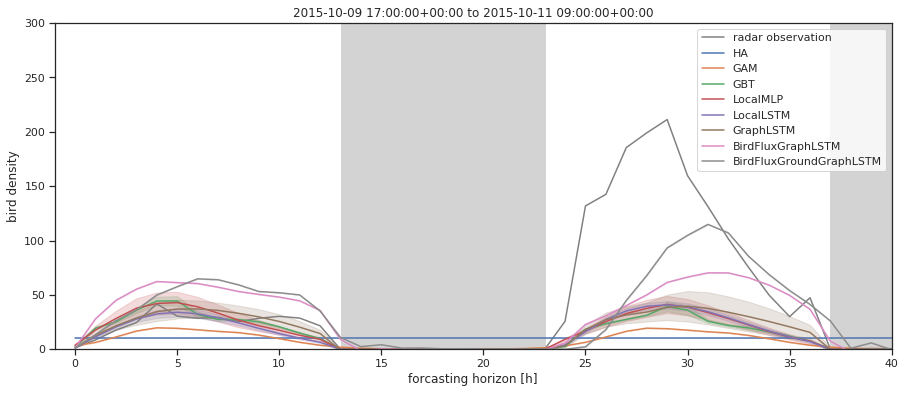

In [7]:
nidx=43
fig = utils.plot_example_prediction(results_fixed_boundary_enforced, 'denhb', nidx, max=300)

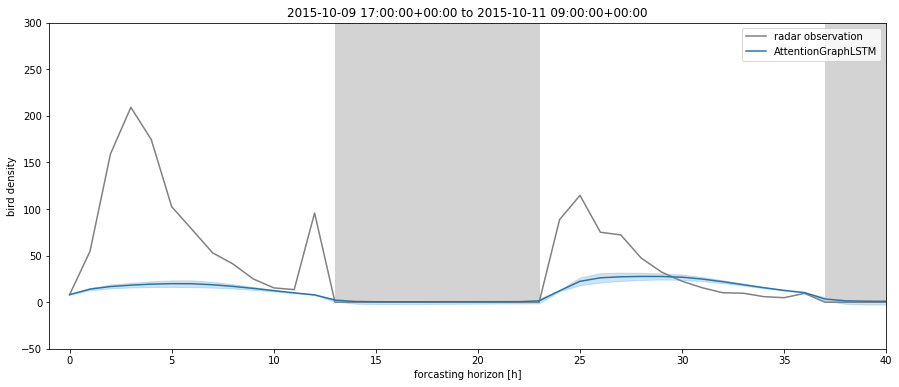

In [22]:
nidx=43
fig = utils.plot_example_prediction(results_att, 'dehnr', nidx, max=300, min=-50)

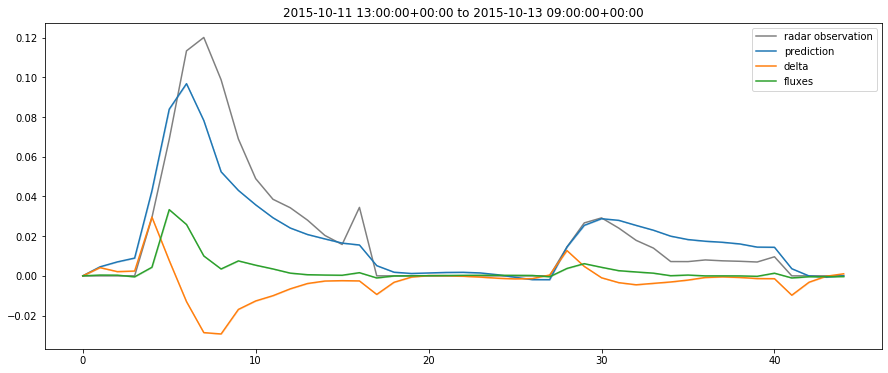

In [23]:
m = 'BirdFluxGraphLSTM'
seqID = 44
radar = 'deumd'
fig, ax = plt.subplots(figsize=(15, 6))

r = results_transformed[m].query(f'seqID == {seqID} & radar == "{radar}"')

r0 = r.query(f'trial == 0')
ax.plot(range(len(r0)), r0['gt'] / bird_scales_transformed[m], label='radar observation', color='gray')

all_predictions = []
all_deltas = []
all_fluxes = []
for trial in r.trial.unique():
    r_t = r.query(f'trial == {trial}')
    all_predictions.append(r_t['prediction'] / bird_scales_transformed[m])
    all_deltas.append(r_t['local_deltas'])
    all_fluxes.append(r_t['fluxes'])
#     all_deltas.append(r_t['delta'])
#     all_fluxes.append(r_t['influx'])
    #print(r_t['local_deltas'])
all_predictions = np.stack(all_predictions, axis=0)
all_deltas = np.stack(all_deltas, axis=0) #* 10
all_fluxes = np.stack(all_fluxes, axis=0)

line = ax.plot(range(all_predictions.shape[1]), all_predictions.mean(0), label='prediction')
ax.fill_between(range(all_predictions.shape[1]), all_predictions.mean(0) - all_predictions.std(0),
                all_predictions.mean(0) + all_predictions.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_deltas.shape[1]), all_deltas.mean(0), label='delta')
ax.fill_between(range(all_deltas.shape[1]), all_deltas.mean(0) - all_deltas.std(0),
                all_deltas.mean(0) + all_deltas.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_fluxes.shape[1]), all_fluxes.mean(0), label='fluxes')
ax.fill_between(range(all_fluxes.shape[1]), all_fluxes.mean(0) - all_fluxes.std(0),
                all_fluxes.mean(0) + all_fluxes.std(0), color=line[0].get_color(), alpha=0.2)

#ax.set(ylim=(0, 0.4), xlim=(-1, 40), xlabel='forcasting horizon [h]', ylabel='normalized bird density')
ax.set_title(f'{r0.datetime.values[0]} to {r0.datetime.values[-1]}')
plt.legend()

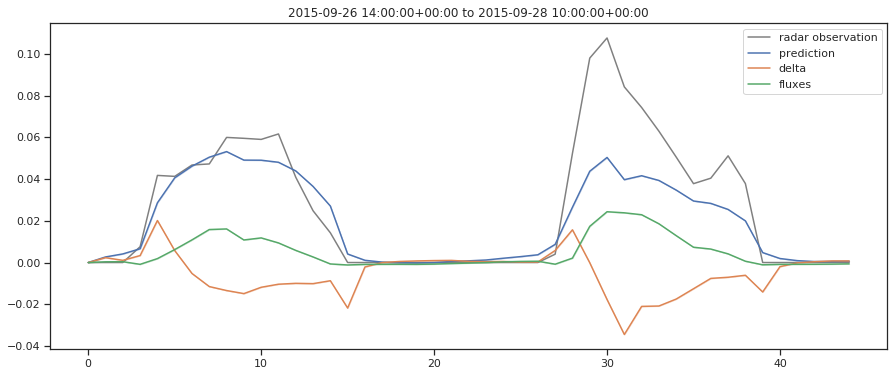

In [19]:
m = 'BirdFluxGraphLSTM'
seqID = 29
radar = 'detur'
fig, ax = plt.subplots(figsize=(15, 6))

r = results_transformed[m].query(f'seqID == {seqID} & radar == "{radar}"')

r0 = r.query(f'trial == 0')
ax.plot(range(len(r0)), r0['gt'] / bird_scales_transformed[m], label='radar observation', color='gray')

all_predictions = []
all_deltas = []
all_fluxes = []
for trial in r.trial.unique():
    r_t = r.query(f'trial == {trial}')
    all_predictions.append(r_t['prediction'] / bird_scales_transformed[m])
    all_deltas.append(r_t['local_deltas'])
    all_fluxes.append(r_t['fluxes'])
#     all_deltas.append(r_t['delta'])
#     all_fluxes.append(r_t['influx'])
    #print(r_t['local_deltas'])
all_predictions = np.stack(all_predictions, axis=0)
all_deltas = np.stack(all_deltas, axis=0) #* 10
all_fluxes = np.stack(all_fluxes, axis=0)

line = ax.plot(range(all_predictions.shape[1]), all_predictions.mean(0), label='prediction')
ax.fill_between(range(all_predictions.shape[1]), all_predictions.mean(0) - all_predictions.std(0),
                all_predictions.mean(0) + all_predictions.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_deltas.shape[1]), all_deltas.mean(0), label='delta')
ax.fill_between(range(all_deltas.shape[1]), all_deltas.mean(0) - all_deltas.std(0),
                all_deltas.mean(0) + all_deltas.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_fluxes.shape[1]), all_fluxes.mean(0), label='fluxes')
ax.fill_between(range(all_fluxes.shape[1]), all_fluxes.mean(0) - all_fluxes.std(0),
                all_fluxes.mean(0) + all_fluxes.std(0), color=line[0].get_color(), alpha=0.2)

#ax.set(ylim=(0, 0.4), xlim=(-1, 40), xlabel='forcasting horizon [h]', ylabel='normalized bird density')
ax.set_title(f'{r0.datetime.values[0]} to {r0.datetime.values[-1]}')
plt.legend()

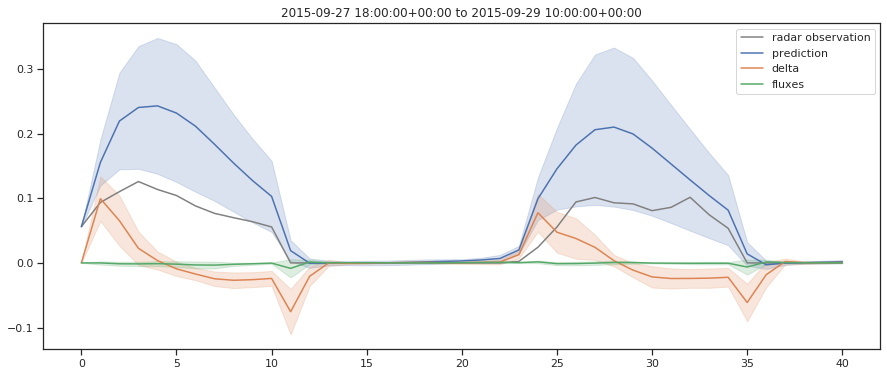

In [37]:
m = 'BirdFluxGraphLSTM'
seqID = 31
radar = 'denhb'
fig, ax = plt.subplots(figsize=(15, 6))

r = results_km2[m].query(f'seqID == {seqID} & radar == "{radar}"')

r0 = r.query(f'trial == 0')
ax.plot(range(len(r0)), r0['gt'] / bird_scales_km2[m], label='radar observation', color='gray')

all_predictions = []
all_deltas = []
all_fluxes = []
for trial in r.trial.unique():
    r_t = r.query(f'trial == {trial}')
    all_predictions.append(r_t['prediction'] / bird_scales_km2[m])
    all_deltas.append(r_t['local_deltas'])
    all_fluxes.append(r_t['fluxes'])
#     all_deltas.append(r_t['delta'])
#     all_fluxes.append(r_t['influx'])
    #print(r_t['local_deltas'])
all_predictions = np.stack(all_predictions, axis=0)
all_deltas = np.stack(all_deltas, axis=0) #* 10
all_fluxes = np.stack(all_fluxes, axis=0)

line = ax.plot(range(all_predictions.shape[1]), all_predictions.mean(0), label='prediction')
ax.fill_between(range(all_predictions.shape[1]), all_predictions.mean(0) - all_predictions.std(0),
                all_predictions.mean(0) + all_predictions.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_deltas.shape[1]), all_deltas.mean(0), label='delta')
ax.fill_between(range(all_deltas.shape[1]), all_deltas.mean(0) - all_deltas.std(0),
                all_deltas.mean(0) + all_deltas.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_fluxes.shape[1]), all_fluxes.mean(0), label='fluxes')
ax.fill_between(range(all_fluxes.shape[1]), all_fluxes.mean(0) - all_fluxes.std(0),
                all_fluxes.mean(0) + all_fluxes.std(0), color=line[0].get_color(), alpha=0.2)

#ax.set(ylim=(0, 0.4), xlim=(-1, 40), xlabel='forcasting horizon [h]', ylabel='normalized bird density')
ax.set_title(f'{r0.datetime.values[0]} to {r0.datetime.values[-1]}')
plt.legend()

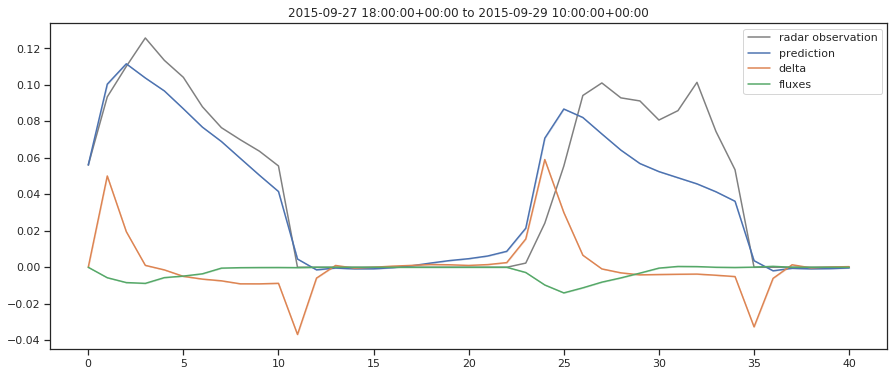

In [56]:
m = 'BirdFluxGraphLSTM'
seqID = 31
radar = 'denhb'
fig, ax = plt.subplots(figsize=(15, 6))

r = results_enforced[m].query(f'seqID == {seqID} & radar == "{radar}"')

r0 = r.query(f'trial == 0')
ax.plot(range(len(r0)), r0['gt'] / bird_scales_enforced[m], label='radar observation', color='gray')

all_predictions = []
all_deltas = []
all_fluxes = []
for trial in r.trial.unique():
    r_t = r.query(f'trial == {trial}')
    all_predictions.append(r_t['prediction'] / bird_scales_enforced[m])
    all_deltas.append(r_t['local_deltas'])
    all_fluxes.append(r_t['fluxes'])
#     all_deltas.append(r_t['delta'])
#     all_fluxes.append(r_t['influx'])
    #print(r_t['local_deltas'])
all_predictions = np.stack(all_predictions, axis=0)
all_deltas = np.stack(all_deltas, axis=0) #* 10
all_fluxes = np.stack(all_fluxes, axis=0)

line = ax.plot(range(all_predictions.shape[1]), all_predictions.mean(0), label='prediction')
ax.fill_between(range(all_predictions.shape[1]), all_predictions.mean(0) - all_predictions.std(0),
                all_predictions.mean(0) + all_predictions.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_deltas.shape[1]), all_deltas.mean(0), label='delta')
ax.fill_between(range(all_deltas.shape[1]), all_deltas.mean(0) - all_deltas.std(0),
                all_deltas.mean(0) + all_deltas.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_fluxes.shape[1]), all_fluxes.mean(0), label='fluxes')
ax.fill_between(range(all_fluxes.shape[1]), all_fluxes.mean(0) - all_fluxes.std(0),
                all_fluxes.mean(0) + all_fluxes.std(0), color=line[0].get_color(), alpha=0.2)

#ax.set(ylim=(0, 0.4), xlim=(-1, 40), xlabel='forcasting horizon [h]', ylabel='normalized bird density')
ax.set_title(f'{r0.datetime.values[0]} to {r0.datetime.values[-1]}')
plt.legend()

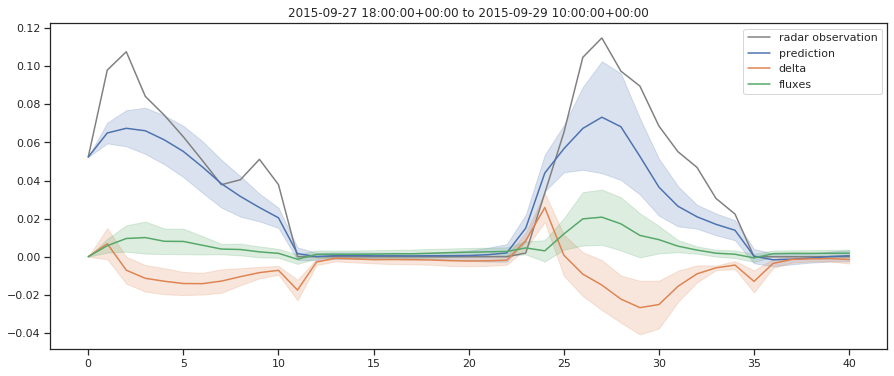

In [33]:
m = 'BirdFluxGraphLSTM'
seqID = 31
radar = 'detur'
fig, ax = plt.subplots(figsize=(15, 6))

r = results_fixed_boundary[m].query(f'seqID == {seqID} & radar == "{radar}"')

r0 = r.query(f'trial == 0')
ax.plot(range(len(r0)), r0['gt'] / bird_scales_fixed_boundary[m], label='radar observation', color='gray')

all_predictions = []
all_deltas = []
all_fluxes = []
for trial in r.trial.unique():
    r_t = r.query(f'trial == {trial}')
    all_predictions.append(r_t['prediction'] / bird_scales_fixed_boundary[m])
    all_deltas.append(r_t['local_deltas'])
    all_fluxes.append(r_t['fluxes'])
#     all_deltas.append(r_t['delta'])
#     all_fluxes.append(r_t['influx'])
    #print(r_t['local_deltas'])
all_predictions = np.stack(all_predictions, axis=0)
all_deltas = np.stack(all_deltas, axis=0) #* 10
all_fluxes = np.stack(all_fluxes, axis=0)

line = ax.plot(range(all_predictions.shape[1]), all_predictions.mean(0), label='prediction')
ax.fill_between(range(all_predictions.shape[1]), all_predictions.mean(0) - all_predictions.std(0),
                all_predictions.mean(0) + all_predictions.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_deltas.shape[1]), all_deltas.mean(0), label='delta')
ax.fill_between(range(all_deltas.shape[1]), all_deltas.mean(0) - all_deltas.std(0),
                all_deltas.mean(0) + all_deltas.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_fluxes.shape[1]), all_fluxes.mean(0), label='fluxes')
ax.fill_between(range(all_fluxes.shape[1]), all_fluxes.mean(0) - all_fluxes.std(0),
                all_fluxes.mean(0) + all_fluxes.std(0), color=line[0].get_color(), alpha=0.2)

#ax.set(ylim=(0, 0.4), xlim=(-1, 40), xlabel='forcasting horizon [h]', ylabel='normalized bird density')
ax.set_title(f'{r0.datetime.values[0]} to {r0.datetime.values[-1]}')
plt.legend()

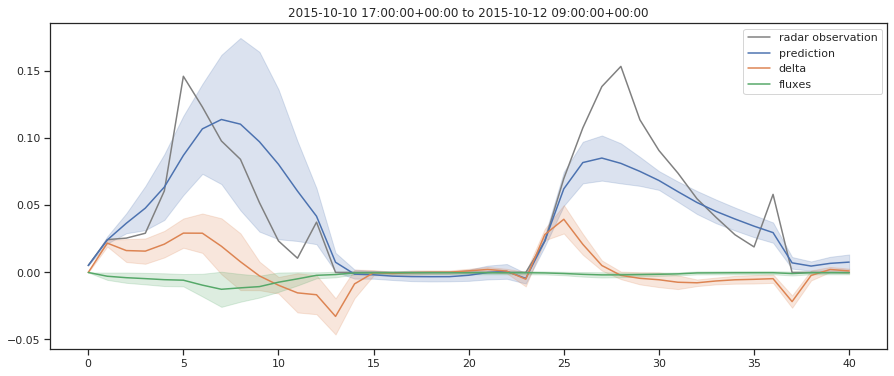

In [35]:
m = 'BirdFluxGraphLSTM'
seqID = 44
radar = 'detur'
fig, ax = plt.subplots(figsize=(15, 6))

r = results_km2[m].query(f'seqID == {seqID} & radar == "{radar}"')

r0 = r.query(f'trial == 0')
ax.plot(range(len(r0)), r0['gt'] / bird_scales_km2[m], label='radar observation', color='gray')

all_predictions = []
all_deltas = []
all_fluxes = []
for trial in r.trial.unique():
    r_t = r.query(f'trial == {trial}')
    all_predictions.append(r_t['prediction'] / bird_scales_km2[m])
    all_deltas.append(r_t['local_deltas'])
    all_fluxes.append(r_t['fluxes'])
#     all_deltas.append(r_t['delta'])
#     all_fluxes.append(r_t['influx'])
    #print(r_t['local_deltas'])
all_predictions = np.stack(all_predictions, axis=0)
all_deltas = np.stack(all_deltas, axis=0) #* 10
all_fluxes = np.stack(all_fluxes, axis=0)

line = ax.plot(range(all_predictions.shape[1]), all_predictions.mean(0), label='prediction')
ax.fill_between(range(all_predictions.shape[1]), all_predictions.mean(0) - all_predictions.std(0),
                all_predictions.mean(0) + all_predictions.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_deltas.shape[1]), all_deltas.mean(0), label='delta')
ax.fill_between(range(all_deltas.shape[1]), all_deltas.mean(0) - all_deltas.std(0),
                all_deltas.mean(0) + all_deltas.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_fluxes.shape[1]), all_fluxes.mean(0), label='fluxes')
ax.fill_between(range(all_fluxes.shape[1]), all_fluxes.mean(0) - all_fluxes.std(0),
                all_fluxes.mean(0) + all_fluxes.std(0), color=line[0].get_color(), alpha=0.2)

#ax.set(ylim=(0, 0.4), xlim=(-1, 40), xlabel='forcasting horizon [h]', ylabel='normalized bird density')
ax.set_title(f'{r0.datetime.values[0]} to {r0.datetime.values[-1]}')
plt.legend()

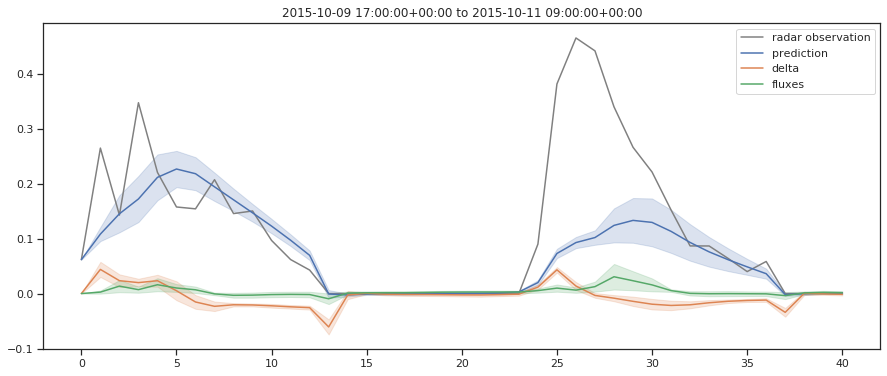

In [28]:
m = 'BirdFluxGraphLSTM'
seqID = 43
radar = 'deess'
fig, ax = plt.subplots(figsize=(15, 6))

r = results_fixed_boundary[m].query(f'seqID == {seqID} & radar == "{radar}"')

r0 = r.query(f'trial == 0')
ax.plot(range(len(r0)), r0['gt'] / bird_scales_fixed_boundary[m], label='radar observation', color='gray')

all_predictions = []
all_deltas = []
all_fluxes = []
for trial in r.trial.unique():
    r_t = r.query(f'trial == {trial}')
    all_predictions.append(r_t['prediction'] / bird_scales_fixed_boundary[m])
    all_deltas.append(r_t['local_deltas'])
    all_fluxes.append(r_t['fluxes'])
#     all_deltas.append(r_t['delta'])
#     all_fluxes.append(r_t['influx'])
    #print(r_t['local_deltas'])
all_predictions = np.stack(all_predictions, axis=0)
all_deltas = np.stack(all_deltas, axis=0) #* 10
all_fluxes = np.stack(all_fluxes, axis=0)

line = ax.plot(range(all_predictions.shape[1]), all_predictions.mean(0), label='prediction')
ax.fill_between(range(all_predictions.shape[1]), all_predictions.mean(0) - all_predictions.std(0),
                all_predictions.mean(0) + all_predictions.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_deltas.shape[1]), all_deltas.mean(0), label='delta')
ax.fill_between(range(all_deltas.shape[1]), all_deltas.mean(0) - all_deltas.std(0),
                all_deltas.mean(0) + all_deltas.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_fluxes.shape[1]), all_fluxes.mean(0), label='fluxes')
ax.fill_between(range(all_fluxes.shape[1]), all_fluxes.mean(0) - all_fluxes.std(0),
                all_fluxes.mean(0) + all_fluxes.std(0), color=line[0].get_color(), alpha=0.2)

#ax.set(ylim=(0, 0.4), xlim=(-1, 40), xlabel='forcasting horizon [h]', ylabel='normalized bird density')
ax.set_title(f'{r0.datetime.values[0]} to {r0.datetime.values[-1]}')
plt.legend()

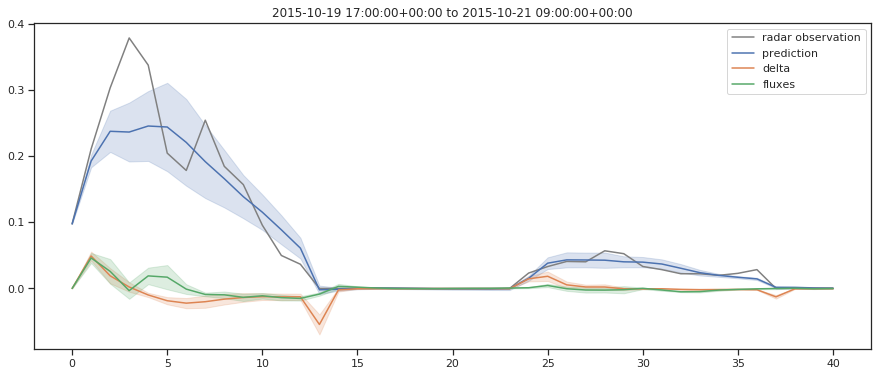

In [91]:
m = 'BirdFluxGraphLSTM'
seqID = 53
radar = 'deess'
fig, ax = plt.subplots(figsize=(15, 6))

r = results_fixed_boundary_enforced[m].query(f'seqID == {seqID} & radar == "{radar}"')

r0 = r.query(f'trial == 0')
ax.plot(range(len(r0)), r0['gt'] / bird_scales_fixed_boundary_enforced[m], label='radar observation', color='gray')

all_predictions = []
all_deltas = []
all_fluxes = []
for trial in r.trial.unique():
    r_t = r.query(f'trial == {trial}')
    all_predictions.append(r_t['prediction'] / bird_scales_fixed_boundary_enforced[m])
    all_deltas.append(r_t['local_deltas'])
    all_fluxes.append(r_t['fluxes'])
#     all_deltas.append(r_t['delta'])
#     all_fluxes.append(r_t['influx'])
    #print(r_t['local_deltas'])
all_predictions = np.stack(all_predictions, axis=0)
all_deltas = np.stack(all_deltas, axis=0) #* 10
all_fluxes = np.stack(all_fluxes, axis=0)

line = ax.plot(range(all_predictions.shape[1]), all_predictions.mean(0), label='prediction')
ax.fill_between(range(all_predictions.shape[1]), all_predictions.mean(0) - all_predictions.std(0),
                all_predictions.mean(0) + all_predictions.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_deltas.shape[1]), all_deltas.mean(0), label='delta')
ax.fill_between(range(all_deltas.shape[1]), all_deltas.mean(0) - all_deltas.std(0),
                all_deltas.mean(0) + all_deltas.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_fluxes.shape[1]), all_fluxes.mean(0), label='fluxes')
ax.fill_between(range(all_fluxes.shape[1]), all_fluxes.mean(0) - all_fluxes.std(0),
                all_fluxes.mean(0) + all_fluxes.std(0), color=line[0].get_color(), alpha=0.2)

#ax.set(ylim=(0, 0.4), xlim=(-1, 40), xlabel='forcasting horizon [h]', ylabel='normalized bird density')
ax.set_title(f'{r0.datetime.values[0]} to {r0.datetime.values[-1]}')
plt.legend()

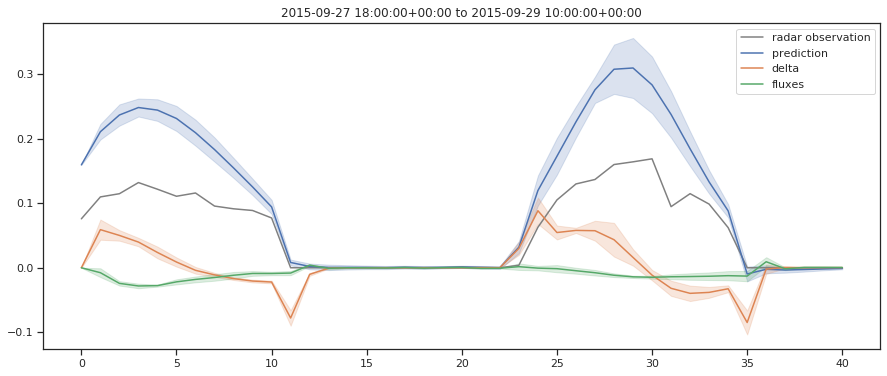

In [100]:
m = 'BirdFluxGraphLSTM'
seqID = 31
radar = 'deess'
fig, ax = plt.subplots(figsize=(15, 6))

r = results_dummy1[m].query(f'seqID == {seqID} & radar == "{radar}"')

r0 = r.query(f'trial == 0')
ax.plot(range(len(r0)), r0['gt'] / bird_scales_dummy1[m], label='radar observation', color='gray')

all_predictions = []
all_deltas = []
all_fluxes = []
for trial in r.trial.unique():
    r_t = r.query(f'trial == {trial}')
    all_predictions.append(r_t['prediction'] / bird_scales_dummy1[m])
    all_deltas.append(r_t['local_deltas'])
    all_fluxes.append(r_t['fluxes'])
#     all_deltas.append(r_t['delta'])
#     all_fluxes.append(r_t['influx'])
    #print(r_t['local_deltas'])
all_predictions = np.stack(all_predictions, axis=0)
all_deltas = np.stack(all_deltas, axis=0) #* 10
all_fluxes = np.stack(all_fluxes, axis=0)

line = ax.plot(range(all_predictions.shape[1]), all_predictions.mean(0), label='prediction')
ax.fill_between(range(all_predictions.shape[1]), all_predictions.mean(0) - all_predictions.std(0),
                all_predictions.mean(0) + all_predictions.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_deltas.shape[1]), all_deltas.mean(0), label='delta')
ax.fill_between(range(all_deltas.shape[1]), all_deltas.mean(0) - all_deltas.std(0),
                all_deltas.mean(0) + all_deltas.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_fluxes.shape[1]), all_fluxes.mean(0), label='fluxes')
ax.fill_between(range(all_fluxes.shape[1]), all_fluxes.mean(0) - all_fluxes.std(0),
                all_fluxes.mean(0) + all_fluxes.std(0), color=line[0].get_color(), alpha=0.2)

#ax.set(ylim=(0, 0.4), xlim=(-1, 40), xlabel='forcasting horizon [h]', ylabel='normalized bird density')
ax.set_title(f'{r0.datetime.values[0]} to {r0.datetime.values[-1]}')
plt.legend()

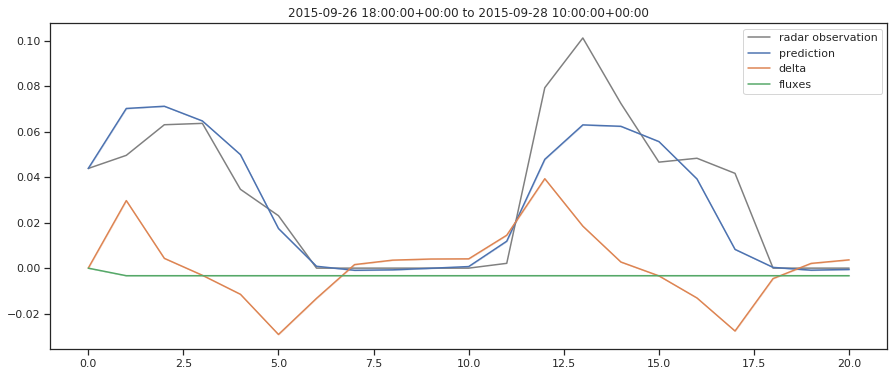

In [37]:
m = 'GraphLSTM'
seqID = 30
radar = 'detur'
fig, ax = plt.subplots(figsize=(15, 6))

r = results_2H[m].query(f'seqID == {seqID} & radar == "{radar}"')

r0 = r.query(f'trial == 0')
ax.plot(range(len(r0)), r0['gt'] / bird_scales_2H[m], label='radar observation', color='gray')

all_predictions = []
all_deltas = []
all_fluxes = []
for trial in r.trial.unique():
    r_t = r.query(f'trial == {trial}')
    all_predictions.append(r_t['prediction'] / bird_scales_2H[m])
    all_deltas.append(r_t['local_deltas'])
    all_fluxes.append(r_t['fluxes'])

all_predictions = np.stack(all_predictions, axis=0)
all_deltas = np.stack(all_deltas, axis=0) #* 10
all_fluxes = np.stack(all_fluxes, axis=0)

line = ax.plot(range(all_predictions.shape[1]), all_predictions.mean(0), label='prediction')
ax.fill_between(range(all_predictions.shape[1]), all_predictions.mean(0) - all_predictions.std(0),
                all_predictions.mean(0) + all_predictions.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_deltas.shape[1]), all_deltas.mean(0), label='delta')
ax.fill_between(range(all_deltas.shape[1]), all_deltas.mean(0) - all_deltas.std(0),
                all_deltas.mean(0) + all_deltas.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_fluxes.shape[1]), all_fluxes.mean(0), label='fluxes')
ax.fill_between(range(all_fluxes.shape[1]), all_fluxes.mean(0) - all_fluxes.std(0),
                all_fluxes.mean(0) + all_fluxes.std(0), color=line[0].get_color(), alpha=0.2)

ax.set_title(f'{r0.datetime.values[0]} to {r0.datetime.values[-1]}')
plt.legend()

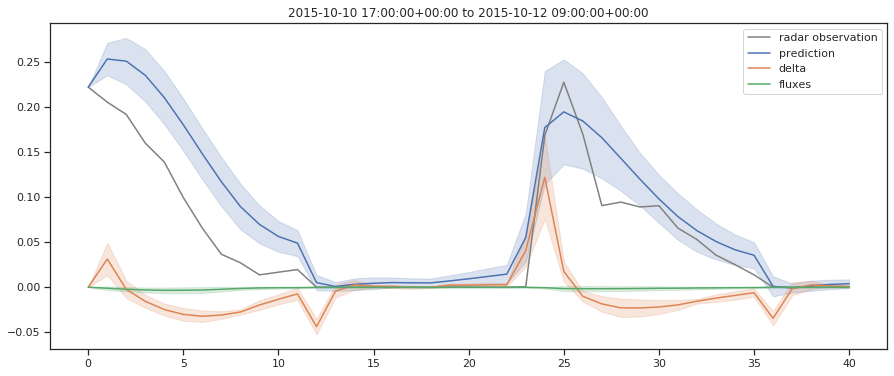

In [38]:
m = 'BirdFluxGraphLSTM'
seqID = 44
radar = 'depro'
fig, ax = plt.subplots(figsize=(15, 6))

r = results_km2[m].query(f'seqID == {seqID} & radar == "{radar}"')

r0 = r.query(f'trial == 0')
ax.plot(range(len(r0)), r0['gt'] / bird_scales_km2[m], label='radar observation', color='gray')

all_predictions = []
all_deltas = []
all_fluxes = []
for trial in r.trial.unique():
    r_t = r.query(f'trial == {trial}')
    all_predictions.append(r_t['prediction'] / bird_scales_km2[m])
    all_deltas.append(r_t['local_deltas'])
    all_fluxes.append(r_t['fluxes'])
#     all_deltas.append(r_t['delta'])
#     all_fluxes.append(r_t['influx'])
    #print(r_t['local_deltas'])
all_predictions = np.stack(all_predictions, axis=0)
all_deltas = np.stack(all_deltas, axis=0) #* 10
all_fluxes = np.stack(all_fluxes, axis=0)

line = ax.plot(range(all_predictions.shape[1]), all_predictions.mean(0), label='prediction')
ax.fill_between(range(all_predictions.shape[1]), all_predictions.mean(0) - all_predictions.std(0),
                all_predictions.mean(0) + all_predictions.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_deltas.shape[1]), all_deltas.mean(0), label='delta')
ax.fill_between(range(all_deltas.shape[1]), all_deltas.mean(0) - all_deltas.std(0),
                all_deltas.mean(0) + all_deltas.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_fluxes.shape[1]), all_fluxes.mean(0), label='fluxes')
ax.fill_between(range(all_fluxes.shape[1]), all_fluxes.mean(0) - all_fluxes.std(0),
                all_fluxes.mean(0) + all_fluxes.std(0), color=line[0].get_color(), alpha=0.2)

#ax.set(ylim=(0, 0.4), xlim=(-1, 40), xlabel='forcasting horizon [h]', ylabel='normalized bird density')
ax.set_title(f'{r0.datetime.values[0]} to {r0.datetime.values[-1]}')
plt.legend()

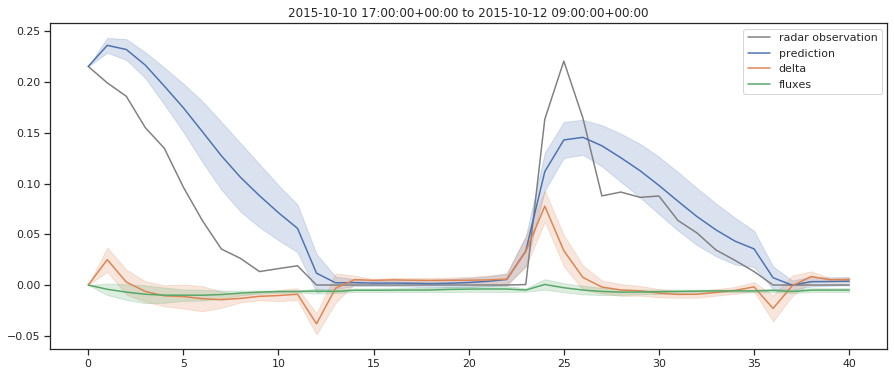

In [39]:
m = 'BirdFluxGraphLSTM'
seqID = 44
radar = 'depro'
fig, ax = plt.subplots(figsize=(15, 6))

r = results_dummy1[m].query(f'seqID == {seqID} & radar == "{radar}"')

r0 = r.query(f'trial == 0')
ax.plot(range(len(r0)), r0['gt'] / bird_scales_dummy1[m], label='radar observation', color='gray')

all_predictions = []
all_deltas = []
all_fluxes = []
for trial in r.trial.unique():
    r_t = r.query(f'trial == {trial}')
    all_predictions.append(r_t['prediction'] / bird_scales_dummy1[m])
    all_deltas.append(r_t['local_deltas'])
    all_fluxes.append(r_t['fluxes'])
#     all_deltas.append(r_t['delta'])
#     all_fluxes.append(r_t['influx'])
    #print(r_t['local_deltas'])
all_predictions = np.stack(all_predictions, axis=0)
all_deltas = np.stack(all_deltas, axis=0) #* 10
all_fluxes = np.stack(all_fluxes, axis=0)

line = ax.plot(range(all_predictions.shape[1]), all_predictions.mean(0), label='prediction')
ax.fill_between(range(all_predictions.shape[1]), all_predictions.mean(0) - all_predictions.std(0),
                all_predictions.mean(0) + all_predictions.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_deltas.shape[1]), all_deltas.mean(0), label='delta')
ax.fill_between(range(all_deltas.shape[1]), all_deltas.mean(0) - all_deltas.std(0),
                all_deltas.mean(0) + all_deltas.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_fluxes.shape[1]), all_fluxes.mean(0), label='fluxes')
ax.fill_between(range(all_fluxes.shape[1]), all_fluxes.mean(0) - all_fluxes.std(0),
                all_fluxes.mean(0) + all_fluxes.std(0), color=line[0].get_color(), alpha=0.2)

#ax.set(ylim=(0, 0.4), xlim=(-1, 40), xlabel='forcasting horizon [h]', ylabel='normalized bird density')
ax.set_title(f'{r0.datetime.values[0]} to {r0.datetime.values[-1]}')
plt.legend()

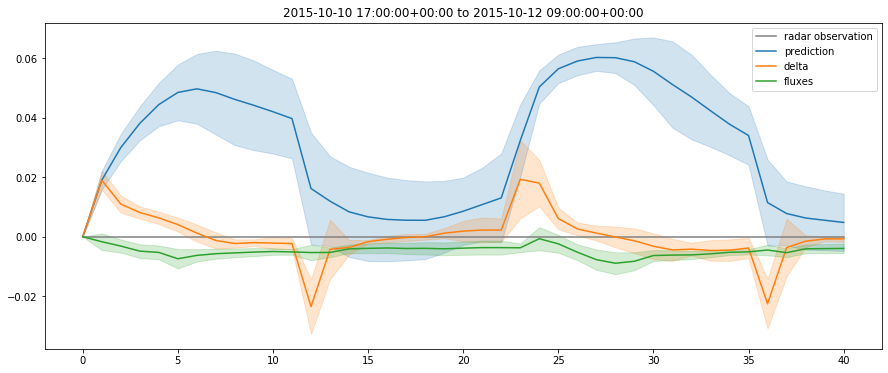

In [17]:
m = 'BirdFluxGraphLSTM'
seqID = 44
radar = 'boundary_5'
fig, ax = plt.subplots(figsize=(15, 6))

r = results_dummy[m].query(f'seqID == {seqID} & radar == "{radar}"')

r0 = r.query(f'trial == 0')
ax.plot(range(len(r0)), r0['gt'] / bird_scales_dummy[m], label='radar observation', color='gray')

all_predictions = []
all_deltas = []
all_fluxes = []
for trial in r.trial.unique():
    r_t = r.query(f'trial == {trial}')
    all_predictions.append(r_t['prediction'] / bird_scales_dummy[m])
    all_deltas.append(r_t['local_deltas'])
    all_fluxes.append(r_t['fluxes'])
#     all_deltas.append(r_t['delta'])
#     all_fluxes.append(r_t['influx'])
    #print(r_t['local_deltas'])
all_predictions = np.stack(all_predictions, axis=0)
all_deltas = np.stack(all_deltas, axis=0) #* 10
all_fluxes = np.stack(all_fluxes, axis=0)

line = ax.plot(range(all_predictions.shape[1]), all_predictions.mean(0), label='prediction')
ax.fill_between(range(all_predictions.shape[1]), all_predictions.mean(0) - all_predictions.std(0),
                all_predictions.mean(0) + all_predictions.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_deltas.shape[1]), all_deltas.mean(0), label='delta')
ax.fill_between(range(all_deltas.shape[1]), all_deltas.mean(0) - all_deltas.std(0),
                all_deltas.mean(0) + all_deltas.std(0), color=line[0].get_color(), alpha=0.2)

line = ax.plot(range(all_fluxes.shape[1]), all_fluxes.mean(0), label='fluxes')
ax.fill_between(range(all_fluxes.shape[1]), all_fluxes.mean(0) - all_fluxes.std(0),
                all_fluxes.mean(0) + all_fluxes.std(0), color=line[0].get_color(), alpha=0.2)

#ax.set(ylim=(0, 0.4), xlim=(-1, 40), xlabel='forcasting horizon [h]', ylabel='normalized bird density')
ax.set_title(f'{r0.datetime.values[0]} to {r0.datetime.values[-1]}')
plt.legend()

## Analysis of BirdFlowGraphLSTM
### Inferred outflux per radar station
The outflux per radar station should equal to 1 at each timestep if no birds are landing and thus moving from the air to the ground.

[Text(0, 0.5, 'total outflux')]

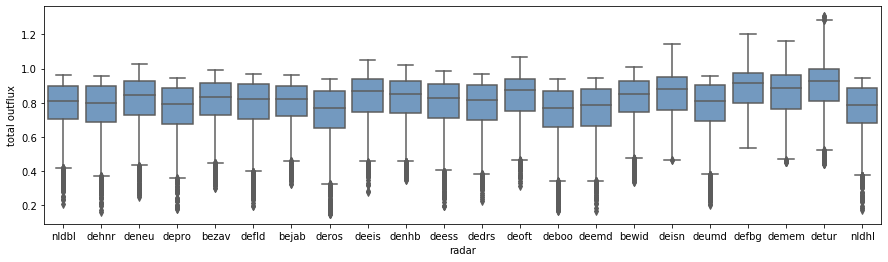

In [41]:
fig, ax = plt.subplots(figsize=(15, 4))
sb.boxplot(x='radar', y='outflux', data=results['BirdFlowGraphLSTM'].query('night == True & horizon != 0'), ax=ax, color='#6699cc') #, ci='sd')
ax.set(ylabel='total outflux')

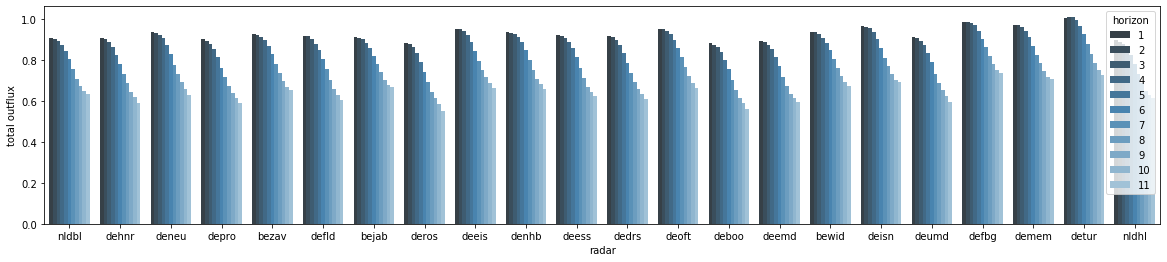

In [28]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='outflux', hue='horizon', data=results['BirdFlowGraphLSTM'].query('night == True & horizon != 0 & horizon < 12'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='total outflux');

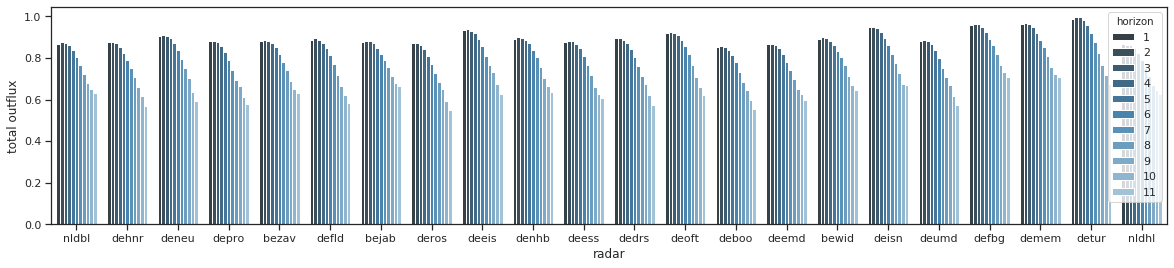

In [85]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='outflux', hue='horizon', data=results_transformed['BirdFlowGraphLSTM'].query('night == True & horizon != 0 & horizon < 12'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='total outflux');

### Inferred number of birds taking off / landing per radar station
If delta < 0, more birds are landing than taking off. Otherwise, more birds are taking off.

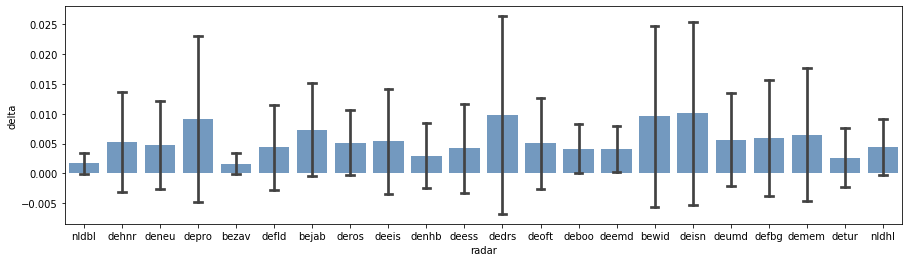

In [46]:
fig, ax = plt.subplots(figsize=(15, 4))
sb.barplot(x='radar', y='delta', data=results['BirdFlowGraphLSTM'].query('night == True & horizon != 0'), ax=ax, color='#6699cc', capsize=.2, ci='sd')

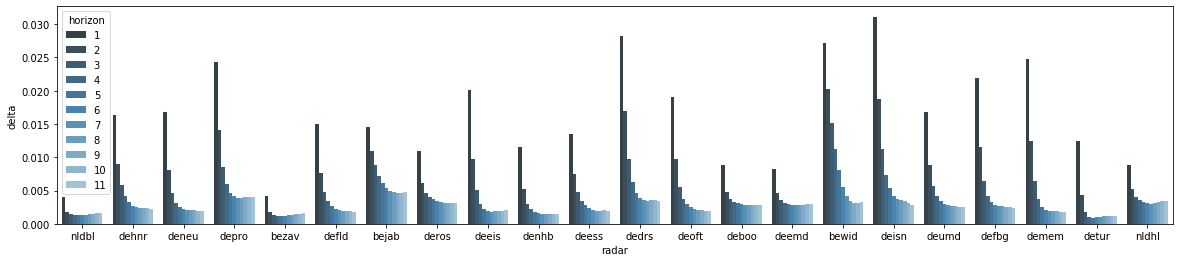

In [18]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='delta', hue='horizon', data=results['BirdFlowGraphLSTM'].query('night == True & horizon != 0 & horizon < 12'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='delta');

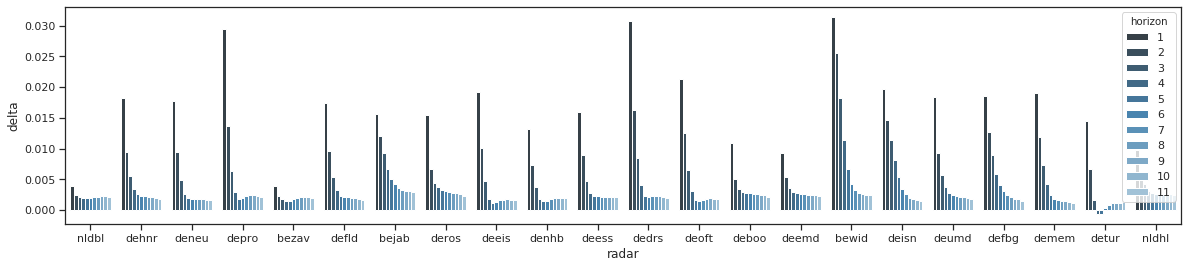

In [81]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='delta', hue='horizon', data=results_transformed['BirdFlowGraphLSTM'].query('night == True & horizon != 0 & horizon < 12'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='delta');

### Analysis of GraphLSTM
#### Inferred total flux from/to neighbors

[Text(0, 0.5, 'total flux from/to neighbors')]

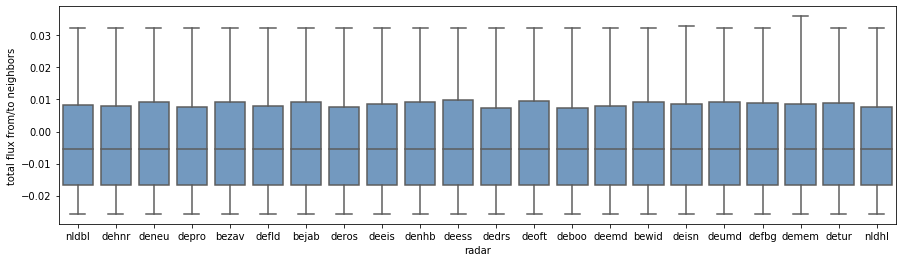

In [10]:
fig, ax = plt.subplots(figsize=(15, 4))
sb.boxplot(x='radar', y='fluxes', data=results['GraphLSTM'].query('night == True & horizon != 0'), ax=ax, color='#6699cc') #, ci='sd')
ax.set(ylabel='total flux from/to neighbors');

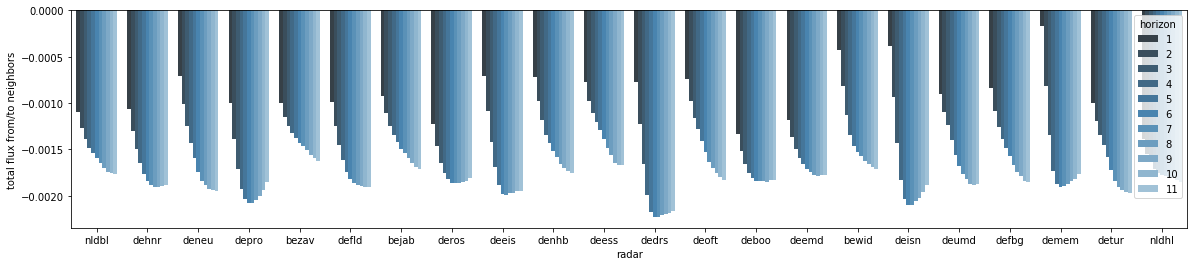

In [17]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='fluxes', hue='horizon', data=results['GraphLSTM'].query('night == True & horizon != 0 & horizon < 12'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='total flux from/to neighbors');

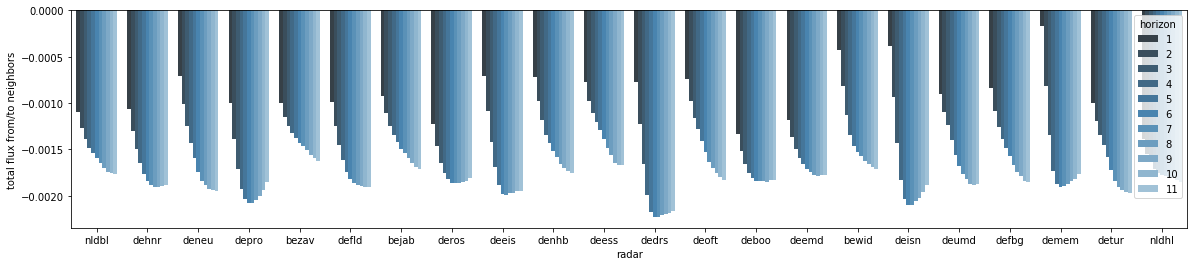

In [7]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='fluxes', hue='horizon', data=results['GraphLSTM'].query('night == True & horizon != 0 & horizon < 12'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='total flux from/to neighbors');

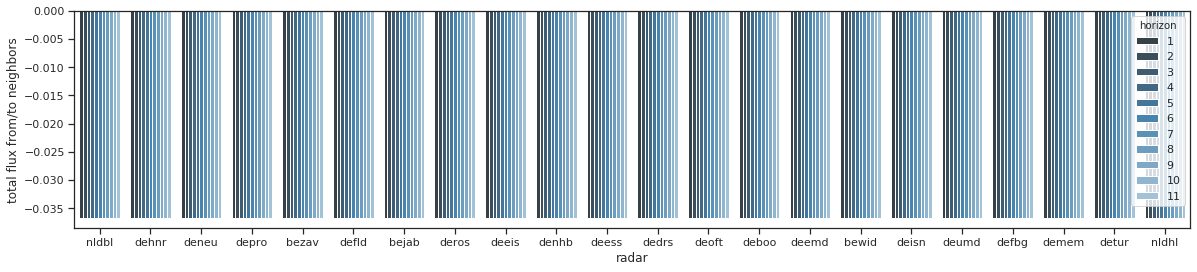

In [84]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='fluxes', hue='horizon', data=results_transformed['GraphLSTM'].query('night == True & horizon != 0 & horizon < 12'), 
           ax=ax, ci=95, palette="Blues_d")
ax.set(ylabel='total flux from/to neighbors');

### Inferred number of birds taking off / landing per radar station
If delta < 0, more birds are landing than taking off. Otherwise, more birds are taking off.

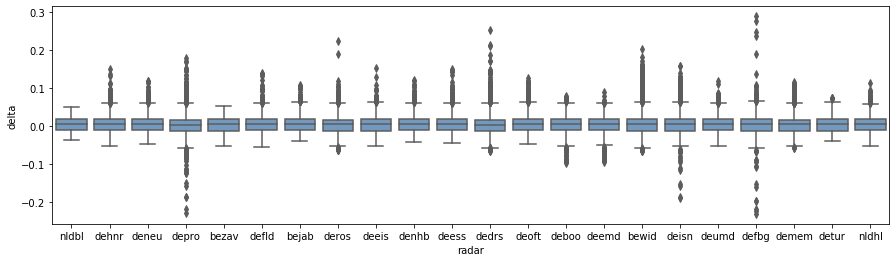

In [15]:
fig, ax = plt.subplots(figsize=(15, 4))
sb.boxplot(x='radar', y='local_deltas', data=results['GraphLSTM'].query('night == True & horizon != 0'), ax=ax, color='#6699cc')#, capsize=.2, ci='sd')
ax.set(ylabel='delta');

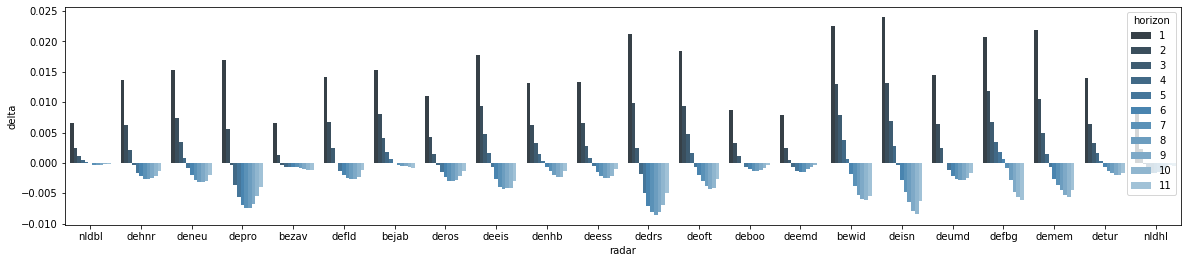

In [12]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='local_deltas', hue='horizon', data=results['GraphLSTM'].query('night == True & horizon != 0 & horizon < 12'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='delta');

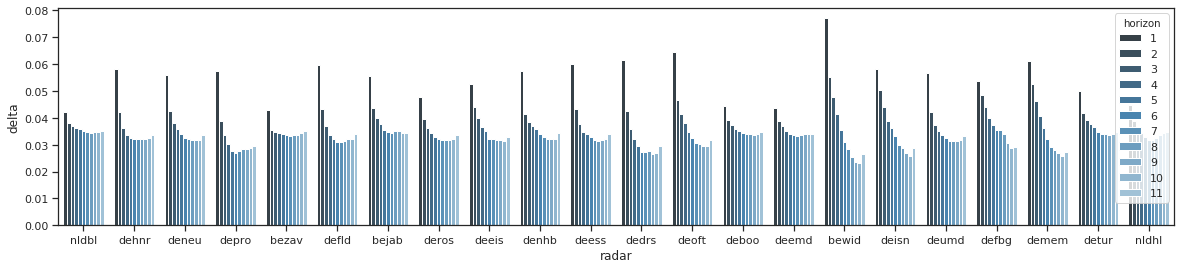

In [82]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='local_deltas', hue='horizon', data=results_transformed['GraphLSTM'].query('night == True & horizon != 0 & horizon < 12'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='delta');

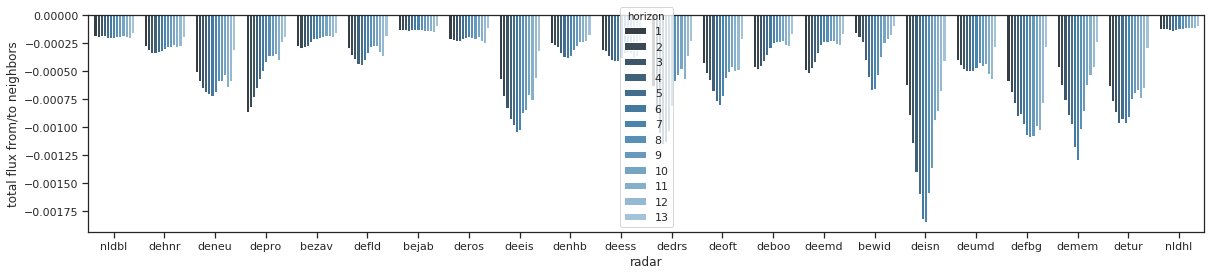

In [24]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='fluxes', hue='horizon', data=results_km2['BirdFluxGraphLSTM'].query('night == True & horizon != 0 & horizon < 14'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='total flux from/to neighbors');

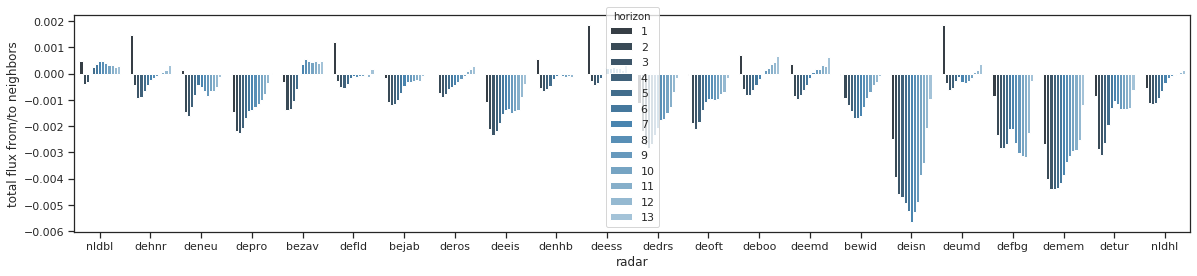

In [29]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='fluxes', hue='horizon', data=results_km2['BirdFluxGraphLSTM'].query('night == True & horizon != 0 & horizon < 14'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='total flux from/to neighbors');

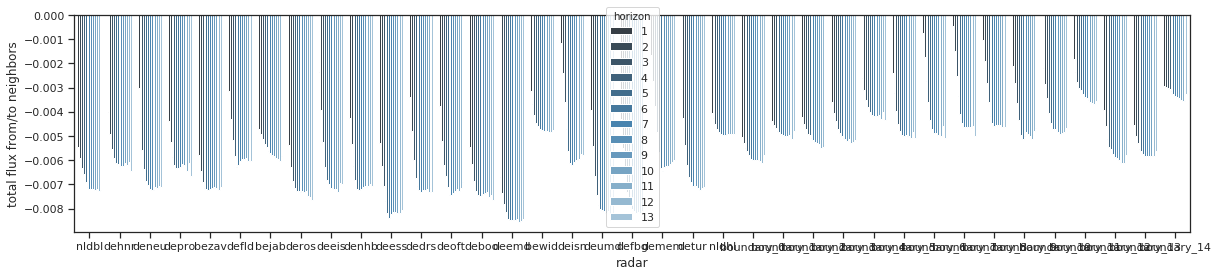

In [26]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='fluxes', hue='horizon', data=results_dummy1['BirdFluxGraphLSTM'].query('night == True & horizon != 0 & horizon < 14'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='total flux from/to neighbors');

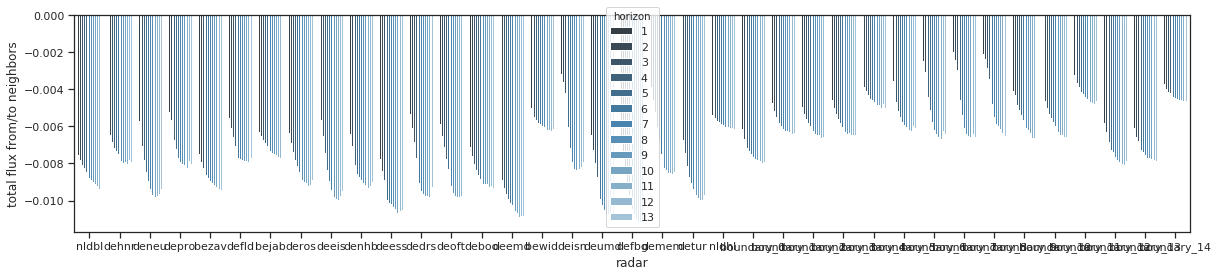

In [30]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='fluxes', hue='horizon', data=results_dummy1['BirdFluxGraphLSTM'].query('night == True & horizon != 0 & horizon < 14'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='total flux from/to neighbors');

In [47]:
results_enforced['BirdFluxGraphLSTM']

Unnamed: 0           gt    gt_km2  prediction  prediction_km2  night  \
0               0   98960.3600  4.965097   98960.360        4.965097   True   
1               1  131417.6000  6.593561  136815.110        6.864368   True   
2               2  119623.6200  6.001827  131557.300        6.600570   True   
3               3  122655.3400  6.153936  125306.305        6.286942   True   
4               4  107930.8300  5.415169  116233.440        5.831733   True   
...           ...          ...       ...         ...             ...    ...   
71253       71253    7676.7407  0.197705  -18012.127       -0.463880   True   
71254       71254       0.0000  0.000000  -23429.234       -0.603391   True   
71255       71255   67201.6000  1.730693  -28687.053       -0.738799   True   
71256       71256       0.0000  0.000000  -33944.870       -0.874208  False   
71257       71257       0.0000  0.000000  -39202.690       -1.009616  False   

       radar  seqID  tidx                   datetime  trial  horizon  missing  \
0      nldbl      0   631  2015-08-27 19:00:00+00:00      0        0    False   
1      nldbl      0   632  2015-08-27 20:00:00+00:00      0        1    False   
2      nldbl      0   633  2015-08-27 21:00:00+00:00      0        2    False   
3      nldbl      0   634  2015-08-27 22:00:00+00:00      0        3    False   
4      nldbl      0   635  2015-08-27 23:00:00+00:00      0        4    False   
...      ...    ...   ...                        ...    ...      ...      ...   
71253  nldhl     78  2536  2015-11-15 04:00:00+00:00      0       36    False   
71254  nldhl     78  2537  2015-11-15 05:00:00+00:00      0       37    False   
71255  nldhl     78  2538  2015-11-15 06:00:00+00:00      0       38    False   
71256  nldhl     78  2539  2015-11-15 07:00:00+00:00      0       39    False   
71257  nldhl     78  2540  2015-11-15 08:00:00+00:00      0       40    False   

       fluxes  local_deltas     error  
0         0.0      0.000000  0.000000  
1         0.0      0.003809  0.073337  
2         0.0     -0.000529  0.358493  
3         0.0     -0.000629  0.017690  
4         0.0     -0.000913  0.173525  
...       ...           ...       ...  
71253     0.0     -0.000785  0.437694  
71254     0.0     -0.000545  0.364080  
71255     0.0     -0.000529  6.098392  
71256     0.0     -0.000529  0.000000  
71257     0.0     -0.000529  0.000000  

[71258 rows x 16 columns]

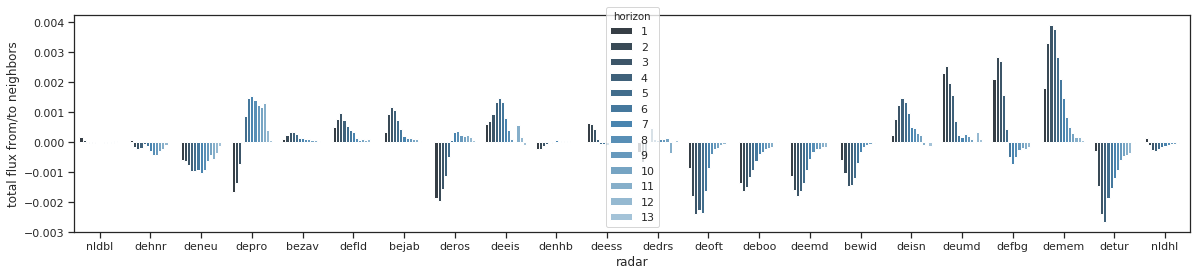

In [49]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='fluxes', hue='horizon', data=results_enforced['BirdFluxGraphLSTM'].query('night == True & horizon != 0 & horizon < 14'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='total flux from/to neighbors');

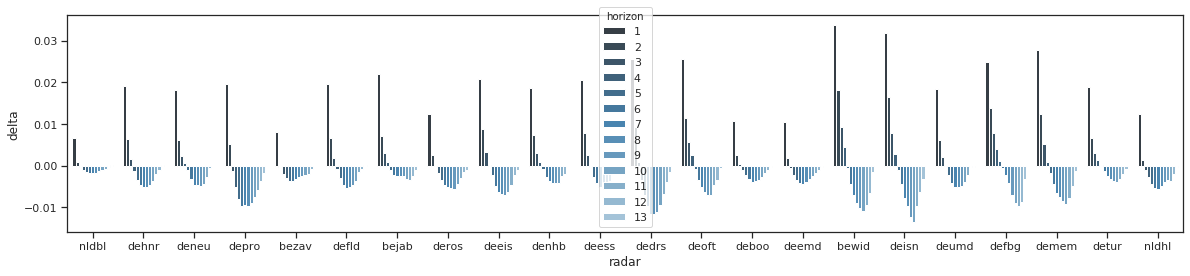

In [25]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='local_deltas', hue='horizon', data=results_km2['BirdFluxGraphLSTM'].query('night == True & horizon != 0 & horizon < 14'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='delta');

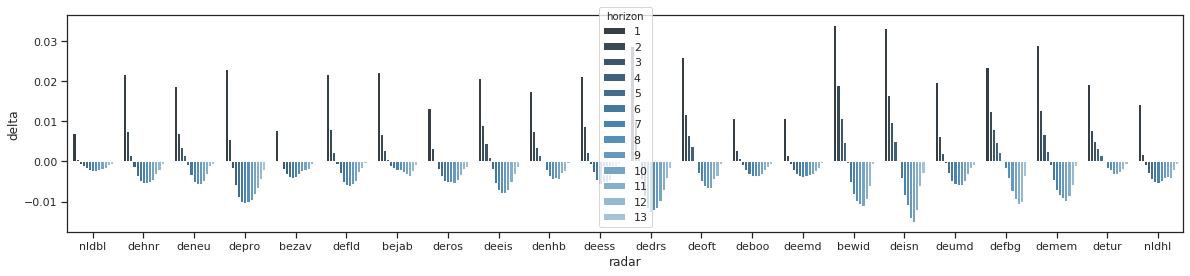

In [31]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='local_deltas', hue='horizon', data=results_km2['BirdFluxGraphLSTM'].query('night == True & horizon != 0 & horizon < 14'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='delta');

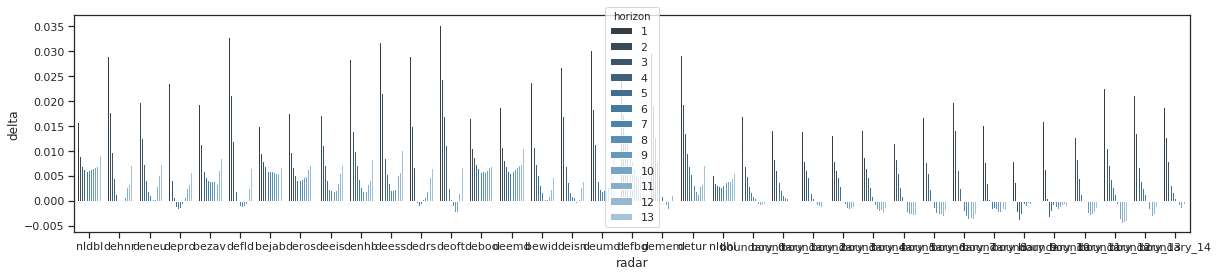

In [32]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='local_deltas', hue='horizon', data=results_dummy1['BirdFluxGraphLSTM'].query('night == True & horizon != 0 & horizon < 14'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='delta');